QP to find the optimal battery operation that minimises the square distance of the residual demand. 3 months time horizon with peiodic boundary condition. No self discharging. Assume energy of 0.8 peak load hours with max power of 0.2 peak load. 

In [1]:
import pandas as pd
import numpy as np
import os 
import pickle

from cvxopt import matrix, solvers


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# battery params
SOCmax=0.8
Xmax=0.2

### compute residuals

In [3]:
# demand factor

file = open('../../preprocessing/s_demand.pkl', 'rb')

s_demand = pickle.load(file)

file.close()

s_demand.describe()



count    87672.000000
mean         0.672161
std          0.092507
min          0.423928
25%          0.601167
50%          0.677592
75%          0.741519
max          1.000000
Name: NEM, dtype: float64

In [4]:
# VRE capacity factor 

file1 = open('../../preprocessing/df_VRE.pkl', 'rb')

df_VRE = pickle.load(file1)

file1.close()

df_VRE.describe()

,NSA_wind,ADE_wind,SESA_wind,NQ_wind,CQ_wind,SWQ_wind,SEQ_wind,NNS_wind,NCEN_wind,SWNSW_wind,...,SEQ_pv,NNS_pv,NCEN_pv,SWNSW_pv,CAN_pv,CVIC_pv,NVIC_pv,MEL_pv,LV_pv,TAS_pv
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,...,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,0.487176,0.518950,0.482749,0.412358,0.399124,0.371925,0.298820,0.369941,0.410580,0.430320,...,0.223738,0.230826,0.224122,0.227533,0.221578,0.220851,0.213939,0.200579,0.191443,0.184123
std,0.250937,0.311564,0.294525,0.186893,0.209994,0.216614,0.232979,0.229998,0.264962,0.256515,...,0.292910,0.300694,0.294765,0.299780,0.302242,0.298624,0.293695,0.280950,0.271458,0.273811
min,0.000170,0.000000,0.000000,0.003431,0.000033,0.000023,0.000000,0.000073,0.000015,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.283203,0.239799,0.226274,0.268482,0.233753,0.195482,0.115597,0.175866,0.176217,0.215271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.487286,0.532403,0.470042,0.412669,0.403292,0.361328,0.243690,0.352348,0.392946,0.422647,...,0.003167,0.004674,0.003822,0.004537,0.001356,0.001878,0.001367,0.001156,0.000933,0.000000
75%,0.689897,0.805126,0.736311,0.553285,0.558590,0.530006,0.435457,0.540617,0.625332,0.633184,...,0.476179,0.497844,0.476866,0.475440,0.440186,0.460181,0.428022,0.382439,0.353978,0.318978
max,0.990404,0.991690,0.991685,0.966683,0.980837,0.986573,0.991660,0.991663,0.991540,0.991620,...,0.921856,0.952050,0.945950,0.952181,0.986578,0.948800,0.957956,0.967111,0.982356,1.000000


In [5]:
# solution of bs=54

file2 = open('result_constrained.pkl', 'rb')

EF = pickle.load(file2)[54]

file2.close()

EF


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
NSA_wind,0.071112,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02,7.111154e-02
ADE_wind,0.142028,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.420278e-01,1.325071e-01,1.203460e-01,1.080554e-01,9.331723e-02,6.762321e-02,3.042757e-03,2.248948e-18
SESA_wind,0.023256,3.428153e-02,3.637881e-02,3.461721e-02,2.551738e-02,2.203335e-02,2.214666e-02,1.595007e-02,5.774087e-03,7.374356e-10,3.248059e-11,9.472411e-11,8.619218e-11,1.918878e-03,8.936365e-03,1.880651e-02,2.452116e-02,1.782857e-02
NQ_wind,0.082693,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02,8.269251e-02
CQ_wind,0.099798,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02,9.979796e-02
SWQ_wind,0.167561,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.675605e-01,1.456528e-01,1.407734e-01
SEQ_wind,0.002059,6.623528e-02,8.229733e-02,1.047659e-01,1.335007e-01,1.419371e-01,1.496986e-01,1.502610e-01,1.483680e-01,1.430869e-01,1.334262e-01,1.161793e-01,1.008941e-01,8.719721e-02,7.293953e-02,4.090244e-02,5.052481e-02,5.646531e-02
NNS_wind,0.116660,1.166602e-01,1.166602e-01,1.166602e-01,1.166602e-01,1.166602e-01,1.166602e-01,1.166602e-01,1.003977e-01,8.328374e-02,6.547368e-02,4.528416e-02,2.799892e-02,1.176592e-02,1.140188e-10,2.422133e-09,2.619867e-11,2.265661e-19
NCEN_wind,0.220176,2.060087e-01,2.039389e-01,1.972689e-01,1.751990e-01,1.606339e-01,1.345031e-01,1.146067e-01,1.004285e-01,9.359326e-02,8.814248e-02,8.082579e-02,7.799005e-02,7.585551e-02,7.308282e-02,5.375712e-02,3.855303e-02,3.102202e-02
SWNSW_wind,0.086327,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,8.632692e-02,7.496364e-02,6.061417e-02,4.934222e-02,3.702204e-02,1.239167e-02,1.157427e-11,-1.488137e-17


In [6]:
df_residual=pd.DataFrame(index=df_VRE.index, columns=EF.columns)
for col in df_residual.columns:
    df_residual[col]=s_demand.values-(df_VRE.values)@(EF[col].values[:32])
    
df_residual

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
AEST,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,-0.315999,-0.273601,-0.258247,-0.234049,-0.195486,-0.170762,-0.133395,-0.105072,-0.065604,-0.036653,-0.014922,0.023272,0.055670,0.084940,0.112313,0.166096,0.241798,0.252072
2000-01-01 01:00:00,-0.307122,-0.267180,-0.252944,-0.230370,-0.193428,-0.169689,-0.133706,-0.106515,-0.069347,-0.042304,-0.021751,0.015403,0.047135,0.075715,0.102729,0.156107,0.232034,0.242798
2000-01-01 02:00:00,-0.308337,-0.272727,-0.260088,-0.239732,-0.205607,-0.183596,-0.150193,-0.124766,-0.090047,-0.064790,-0.045381,-0.009532,0.021399,0.049138,0.075423,0.127133,0.200571,0.211641
2000-01-01 03:00:00,-0.291623,-0.263891,-0.253862,-0.236970,-0.207141,-0.187550,-0.157597,-0.134169,-0.101667,-0.077778,-0.059047,-0.024077,0.006489,0.033766,0.059489,0.109548,0.178933,0.189809
2000-01-01 04:00:00,-0.278602,-0.259734,-0.252352,-0.238957,-0.213332,-0.195735,-0.168524,-0.146375,-0.114806,-0.091168,-0.072051,-0.036643,-0.005539,0.022130,0.047993,0.097765,0.163315,0.173001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 19:00:00,-0.097862,-0.080270,-0.069448,-0.054036,-0.033265,-0.016849,0.005660,0.024306,0.059374,0.088110,0.111811,0.151911,0.186153,0.217529,0.245972,0.294435,0.364269,0.371378
2009-12-31 20:00:00,-0.078661,-0.070389,-0.063227,-0.052777,-0.037931,-0.025427,-0.007819,0.007498,0.038436,0.064444,0.086210,0.125453,0.160838,0.192693,0.221792,0.271087,0.336354,0.345669
2009-12-31 21:00:00,-0.085068,-0.077824,-0.071778,-0.063771,-0.051569,-0.041473,-0.026878,-0.014711,0.012183,0.035148,0.054630,0.095003,0.134059,0.168183,0.200109,0.254646,0.320786,0.327570


In [7]:
df_residual.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,-0.154998,-0.125494,-0.112244,-0.093790,-0.065322,-0.044067,-0.012481,0.011951,0.049571,0.079008,0.103902,0.144411,0.178421,0.208476,0.235926,0.287085,0.333118,0.341957
std,0.286710,0.266544,0.259305,0.249913,0.237081,0.228495,0.216595,0.207935,0.195162,0.185694,0.178032,0.165851,0.155924,0.147426,0.139891,0.126701,0.117552,0.117397
min,-1.319523,-1.230976,-1.192645,-1.142132,-1.069263,-1.019387,-0.943282,-0.883987,-0.786934,-0.709335,-0.646949,-0.550874,-0.468917,-0.397260,-0.333250,-0.216820,-0.145527,-0.143439
25%,-0.327589,-0.287690,-0.271318,-0.248082,-0.212487,-0.186541,-0.148544,-0.119128,-0.074030,-0.039136,-0.010035,0.037830,0.077783,0.113055,0.145218,0.204086,0.255889,0.265131
50%,-0.130212,-0.106283,-0.094563,-0.077913,-0.051484,-0.031860,-0.002469,0.021107,0.056583,0.084683,0.108068,0.146941,0.179875,0.208747,0.235152,0.284320,0.329316,0.338326
75%,0.042744,0.057060,0.065190,0.076735,0.096232,0.111015,0.133891,0.151909,0.180431,0.203084,0.222216,0.254113,0.280955,0.304747,0.326920,0.369204,0.408478,0.416997
max,0.736450,0.732590,0.731550,0.730175,0.733121,0.737240,0.743646,0.746745,0.753157,0.758633,0.763028,0.770415,0.776969,0.782655,0.788364,0.798284,0.808225,0.814752


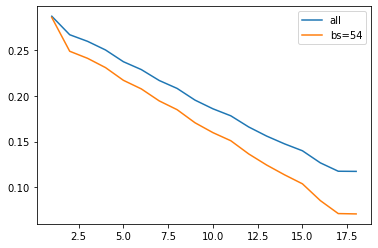

In [8]:
plt.plot(df_residual.std(), label='all')
plt.plot(np.sqrt(EF.loc['sigma_sq']), label='bs=54')
plt.legend()
plt.show()

### battery QP

In [9]:
years=df_residual.index.year.unique().to_list()
month_segments=[[1,3], [4,6], [7,9], [10,12]]


# initialise output
df=df_residual.copy()


df_charge=pd.DataFrame(index=df.index, columns=df.columns)
df_charge.index.name='AEST'


for col in df.columns:
#for col in df.columns[:2]: #for testing

    for year in years:
    #for year in [2000]: # for testing
        for month_segment in month_segments:
            # select time horizon
            s_rdemand=df.loc[(df.index.year==year) & (df.index.month>=month_segment[0]) &
                            (df.index.month<=month_segment[1]), col].copy()

            ##############
            # quadratic objective
            ##############
            T=len(s_rdemand)
            Q=matrix(np.eye(T)) # Q martrix
            p=matrix(s_rdemand.values) # p vector

            ##############
            # Inequality constraints
            ##############

            ### power / charge rate constraints
            l=np.array([])
            u=np.array([])


            for r in s_rdemand.values:
                if r>0:
                    l=np.append(l, max(-Xmax, -r))
                    u=np.append(u, 0)
                else:
                    l=np.append(l, 0)
                    u=np.append(u, min(Xmax, -r))

            A_rate=np.vstack([np.eye(T), -np.eye(T)])
            b_rate=np.concatenate([u, -l])


            ### SOC constraints

            #no self-discharge
            M_ltri=np.tril(np.ones((len(s_rdemand),len(s_rdemand)))) 
            A_soc=np.vstack([M_ltri, -M_ltri]) 


            # periodic boundary condition with 0.5 time SOCmax on either end
            b1=np.repeat(SOCmax/2, T)
            b2=np.repeat(SOCmax/2, T)
            b1[-1]=0.0000001 # add an epsilon to avoid equality
            b2[-1]=0.0000001 # add an epsilon to avoid equality with the above

            b_soc=np.concatenate([b1, b2])

            ### combine
            A=matrix(np.vstack([A_rate, A_soc]))
            b=matrix(np.concatenate([b_rate, b_soc]))

            sol=solvers.qp(Q, p, G=A,h=b)

            v_charge=np.array(sol['x']).ravel()
            v_shifted=s_rdemand.values+v_charge


            # update
            df.loc[(df.index.year==year) & (df.index.month>=month_segment[0]) &
                            (df.index.month<=month_segment[1]), col]=v_shifted
            df_charge.loc[(df_charge.index.year==year) & (df_charge.index.month>=month_segment[0]) &
                            (df_charge.index.month<=month_segment[1]), col]=v_charge

            print(col, year, month_segment, SOCmax/2+v_charge.sum())





     pcost       dcost       gap    pres   dres
 0: -3.6517e+00 -2.3646e+03  1e+04  4e+00  1e-11
 1: -3.6417e+00 -1.4172e+03  2e+03  2e-01  1e-12
 2: -4.1748e+00 -3.3645e+02  4e+02  3e-02  4e-12
 3: -5.0783e+00 -7.9002e+01  8e+01  6e-03  9e-13
 4: -7.1872e+00 -4.0951e+01  3e+01  1e-03  4e-12
 5: -8.7671e+00 -2.4183e+01  2e+01  3e-04  2e-11
 6: -1.0001e+01 -1.8815e+01  9e+00  8e-05  2e-10
 7: -1.0772e+01 -1.4328e+01  4e+00  2e-05  1e-08
 8: -1.1226e+01 -1.2357e+01  1e+00  4e-06  2e-08
 9: -1.1347e+01 -1.1871e+01  5e-01  1e-06  1e-08
10: -1.1429e+01 -1.1617e+01  2e-01  3e-07  2e-07
11: -1.1468e+01 -1.1500e+01  3e-02  2e-15  3e-08
12: -1.1476e+01 -1.1481e+01  4e-03  1e-15  2e-08
13: -1.1478e+01 -1.1478e+01  6e-04  2e-15  2e-09
14: -1.1478e+01 -1.1478e+01  1e-04  9e-16  4e-10
15: -1.1478e+01 -1.1478e+01  4e-06  2e-15  4e-11
Optimal solution found.
1 2000 [1, 3] 0.3999999979179915
     pcost       dcost       gap    pres   dres
 0: -5.8127e+00 -2.4039e+03  1e+04  4e+00  1e-11
 1: -5.7923e+0

 1: -5.1989e+00 -1.4453e+03  2e+03  2e-01  1e-12
 2: -5.4841e+00 -3.7165e+02  4e+02  3e-02  3e-12
 3: -6.5560e+00 -8.1092e+01  8e+01  5e-03  2e-12
 4: -9.0900e+00 -4.4440e+01  4e+01  1e-03  7e-12
 5: -1.0484e+01 -2.9263e+01  2e+01  3e-04  4e-11
 6: -1.1744e+01 -1.9531e+01  8e+00  9e-05  2e-09
 7: -1.2203e+01 -1.7147e+01  5e+00  3e-05  6e-09
 8: -1.2686e+01 -1.4735e+01  2e+00  1e-05  2e-08
 9: -1.2837e+01 -1.3944e+01  1e+00  4e-06  7e-09
10: -1.3017e+01 -1.3254e+01  2e-01  7e-07  2e-07
11: -1.3044e+01 -1.3137e+01  9e-02  7e-08  9e-08
12: -1.3060e+01 -1.3089e+01  3e-02  2e-08  2e-07
13: -1.3066e+01 -1.3071e+01  4e-03  1e-15  3e-08
14: -1.3067e+01 -1.3068e+01  1e-04  1e-15  8e-10
15: -1.3067e+01 -1.3067e+01  2e-05  1e-15  9e-11
16: -1.3067e+01 -1.3067e+01  5e-07  2e-15  4e-11
Optimal solution found.
1 2002 [4, 6] 0.39999990055563556
     pcost       dcost       gap    pres   dres
 0: -6.8414e+00 -2.4808e+03  1e+04  4e+00  4e-12
 1: -6.2402e+00 -1.4987e+03  2e+03  2e-01  1e-12
 2: -6.9007e

 2: -6.9697e+00 -4.2193e+02  5e+02  3e-02  4e-12
 3: -8.4289e+00 -1.0014e+02  1e+02  7e-03  2e-12
 4: -1.1774e+01 -5.8485e+01  5e+01  2e-03  4e-12
 5: -1.4179e+01 -3.4035e+01  2e+01  4e-04  2e-10
 6: -1.5388e+01 -2.7848e+01  1e+01  2e-04  1e-09
 7: -1.6761e+01 -2.0554e+01  4e+00  4e-05  1e-08
 8: -1.7119e+01 -1.8982e+01  2e+00  7e-06  4e-09
 9: -1.7351e+01 -1.8190e+01  8e-01  2e-06  5e-09
10: -1.7500e+01 -1.7702e+01  2e-01  2e-07  2e-08
11: -1.7540e+01 -1.7583e+01  4e-02  2e-08  5e-08
12: -1.7542e+01 -1.7577e+01  3e-02  1e-08  2e-08
13: -1.7550e+01 -1.7556e+01  5e-03  2e-15  9e-09
14: -1.7552e+01 -1.7552e+01  2e-04  2e-15  5e-10
15: -1.7552e+01 -1.7552e+01  2e-05  2e-15  1e-10
Optimal solution found.
1 2004 [7, 9] 0.39999991361864373
     pcost       dcost       gap    pres   dres
 0: -4.5793e+00 -2.4541e+03  1e+04  4e+00  1e-11
 1: -4.4744e+00 -1.4731e+03  2e+03  2e-01  2e-12
 2: -5.3731e+00 -3.6495e+02  4e+02  3e-02  3e-12
 3: -6.8937e+00 -9.3183e+01  9e+01  6e-03  1e-12
 4: -1.0026e

 8: -1.3992e+01 -1.5387e+01  1e+00  8e-06  3e-08
 9: -1.4123e+01 -1.4897e+01  8e-01  3e-06  1e-08
10: -1.4175e+01 -1.4675e+01  5e-01  4e-07  6e-09
11: -1.4270e+01 -1.4435e+01  2e-01  1e-07  1e-07
12: -1.4284e+01 -1.4397e+01  1e-01  5e-08  8e-08
13: -1.4312e+01 -1.4329e+01  2e-02  5e-09  4e-08
14: -1.4315e+01 -1.4322e+01  7e-03  2e-09  1e-08
15: -1.4317e+01 -1.4319e+01  2e-03  3e-10  3e-09
16: -1.4317e+01 -1.4318e+01  2e-04  2e-11  3e-10
17: -1.4317e+01 -1.4317e+01  1e-05  1e-12  5e-11
Optimal solution found.
1 2006 [10, 12] 0.40000009717153223
     pcost       dcost       gap    pres   dres
 0: -3.7544e+00 -2.3716e+03  1e+04  4e+00  1e-11
 1: -3.8448e+00 -1.4208e+03  2e+03  2e-01  2e-12
 2: -4.8122e+00 -3.2626e+02  4e+02  3e-02  3e-12
 3: -6.2393e+00 -8.3060e+01  8e+01  5e-03  1e-12
 4: -9.2570e+00 -4.1162e+01  3e+01  9e-04  4e-12
 5: -1.1170e+01 -2.3786e+01  1e+01  2e-04  4e-11
 6: -1.2279e+01 -1.8768e+01  6e+00  4e-05  2e-10
 7: -1.3073e+01 -1.4837e+01  2e+00  7e-06  2e-09
 8: -1.332

13: -1.3860e+01 -1.3860e+01  4e-04  2e-15  2e-09
14: -1.3860e+01 -1.3860e+01  7e-05  2e-15  2e-10
15: -1.3860e+01 -1.3860e+01  1e-06  2e-15  1e-10
Optimal solution found.
1 2009 [1, 3] 0.4000000995637589
     pcost       dcost       gap    pres   dres
 0: -5.1790e+00 -2.4434e+03  2e+04  4e+00  7e-12
 1: -4.7763e+00 -1.5645e+03  2e+03  3e-01  1e-12
 2: -5.1928e+00 -4.0047e+02  5e+02  4e-02  5e-12
 3: -6.2938e+00 -7.6408e+01  7e+01  6e-03  1e-12
 4: -8.3610e+00 -3.8851e+01  3e+01  2e-03  3e-12
 5: -1.0824e+01 -3.1992e+01  2e+01  3e-04  2e-11
 6: -1.2104e+01 -1.9839e+01  8e+00  8e-05  7e-10
 7: -1.2836e+01 -1.6594e+01  4e+00  3e-05  5e-10
 8: -1.3308e+01 -1.4597e+01  1e+00  4e-06  4e-09
 9: -1.3488e+01 -1.3958e+01  5e-01  1e-06  9e-08
10: -1.3540e+01 -1.3788e+01  2e-01  4e-07  9e-08
11: -1.3559e+01 -1.3714e+01  2e-01  4e-08  1e-08
12: -1.3589e+01 -1.3638e+01  5e-02  1e-08  1e-06
13: -1.3601e+01 -1.3608e+01  7e-03  1e-10  5e-08
14: -1.3603e+01 -1.3604e+01  1e-03  2e-11  8e-09
15: -1.3603e+

14: -1.4348e+01 -1.4349e+01  2e-04  3e-11  9e-10
15: -1.4348e+01 -1.4348e+01  1e-05  3e-13  5e-11
Optimal solution found.
2 2001 [4, 6] 0.3999999008071181
     pcost       dcost       gap    pres   dres
 0: -5.9007e+00 -2.4753e+03  2e+04  4e+00  5e-12
 1: -5.5079e+00 -1.5584e+03  2e+03  3e-01  3e-12
 2: -6.4388e+00 -3.3416e+02  4e+02  3e-02  3e-12
 3: -7.9114e+00 -8.0939e+01  8e+01  5e-03  8e-13
 4: -1.1097e+01 -4.6521e+01  4e+01  2e-03  8e-12
 5: -1.3381e+01 -2.7885e+01  1e+01  3e-04  3e-11
 6: -1.4470e+01 -2.2152e+01  8e+00  1e-04  1e-10
 7: -1.5235e+01 -1.8326e+01  3e+00  2e-05  5e-09
 8: -1.5556e+01 -1.6932e+01  1e+00  7e-06  9e-09
 9: -1.5800e+01 -1.6048e+01  2e-01  9e-07  7e-08
10: -1.5844e+01 -1.5910e+01  7e-02  2e-07  2e-08
11: -1.5854e+01 -1.5878e+01  2e-02  5e-08  1e-08
12: -1.5859e+01 -1.5862e+01  2e-03  1e-15  7e-09
13: -1.5860e+01 -1.5860e+01  2e-04  2e-15  1e-09
14: -1.5860e+01 -1.5860e+01  1e-05  1e-15  3e-10
Optimal solution found.
2 2001 [7, 9] 0.40000009934138453
    

13: -1.4916e+01 -1.4917e+01  1e-03  2e-10  7e-09
14: -1.4916e+01 -1.4916e+01  8e-05  1e-11  4e-10
15: -1.4916e+01 -1.4916e+01  4e-05  4e-12  2e-10
16: -1.4916e+01 -1.4916e+01  8e-07  6e-14  2e-10
Optimal solution found.
2 2003 [7, 9] 0.3999999002052278
     pcost       dcost       gap    pres   dres
 0: -4.1784e+00 -2.4342e+03  1e+04  4e+00  2e-11
 1: -4.2367e+00 -1.4564e+03  2e+03  2e-01  2e-12
 2: -5.3960e+00 -3.8460e+02  4e+02  3e-02  1e-11
 3: -6.9783e+00 -9.5228e+01  9e+01  6e-03  2e-12
 4: -1.0237e+01 -4.2425e+01  3e+01  1e-03  7e-12
 5: -1.1957e+01 -3.4489e+01  2e+01  4e-04  6e-11
 6: -1.3609e+01 -2.1685e+01  8e+00  1e-04  1e-09
 7: -1.4379e+01 -1.8271e+01  4e+00  2e-05  6e-10
 8: -1.4898e+01 -1.6098e+01  1e+00  5e-06  3e-08
 9: -1.4996e+01 -1.5696e+01  7e-01  2e-06  2e-08
10: -1.5123e+01 -1.5272e+01  1e-01  2e-07  4e-07
11: -1.5148e+01 -1.5192e+01  4e-02  3e-08  4e-08
12: -1.5155e+01 -1.5171e+01  2e-02  7e-09  2e-08
13: -1.5158e+01 -1.5164e+01  6e-03  1e-15  2e-09
14: -1.5159e+

     pcost       dcost       gap    pres   dres
 0: -3.2758e+00 -2.2625e+03  2e+04  4e+00  5e-12
 1: -3.4669e+00 -1.4101e+03  2e+03  3e-01  2e-12
 2: -4.3170e+00 -3.4322e+02  4e+02  4e-02  5e-12
 3: -5.3350e+00 -8.3259e+01  8e+01  7e-03  1e-12
 4: -7.9003e+00 -3.4931e+01  3e+01  9e-04  5e-12
 5: -9.2866e+00 -2.6626e+01  2e+01  4e-04  2e-10
 6: -1.0386e+01 -1.8183e+01  8e+00  1e-04  2e-09
 7: -1.1039e+01 -1.4369e+01  3e+00  4e-05  9e-09
 8: -1.1089e+01 -1.4014e+01  3e+00  3e-05  6e-09
 9: -1.1402e+01 -1.2451e+01  1e+00  7e-06  5e-09
10: -1.1526e+01 -1.1915e+01  4e-01  2e-06  8e-09
11: -1.1591e+01 -1.1645e+01  5e-02  6e-08  2e-08
12: -1.1602e+01 -1.1611e+01  9e-03  1e-08  2e-08
13: -1.1604e+01 -1.1606e+01  2e-03  2e-09  3e-09
14: -1.1604e+01 -1.1604e+01  2e-04  9e-11  3e-10
15: -1.1604e+01 -1.1604e+01  1e-05  2e-12  5e-11
Optimal solution found.
2 2006 [1, 3] 0.4000000993126394
     pcost       dcost       gap    pres   dres
 0: -5.3445e+00 -2.4430e+03  1e+04  4e+00  8e-12
 1: -5.1866e+0

 3: -6.6607e+00 -8.8687e+01  9e+01  7e-03  2e-12
 4: -9.2102e+00 -4.2490e+01  3e+01  2e-03  5e-12
 5: -1.1278e+01 -3.2739e+01  2e+01  4e-04  2e-11
 6: -1.2564e+01 -2.0862e+01  8e+00  1e-04  2e-10
 7: -1.3084e+01 -1.7997e+01  5e+00  2e-05  5e-10
 8: -1.3719e+01 -1.5027e+01  1e+00  5e-06  2e-08
 9: -1.3894e+01 -1.4311e+01  4e-01  8e-07  9e-09
10: -1.3946e+01 -1.4122e+01  2e-01  1e-07  3e-08
11: -1.3984e+01 -1.4010e+01  3e-02  1e-08  2e-07
12: -1.3990e+01 -1.3995e+01  5e-03  2e-09  3e-08
13: -1.3991e+01 -1.3991e+01  6e-04  1e-10  2e-09
14: -1.3991e+01 -1.3991e+01  4e-05  6e-12  1e-10
15: -1.3991e+01 -1.3991e+01  4e-07  6e-14  2e-10
Optimal solution found.
2 2008 [4, 6] 0.4000000999035502
     pcost       dcost       gap    pres   dres
 0: -6.5525e+00 -2.4751e+03  1e+04  4e+00  1e-11
 1: -6.3937e+00 -1.4963e+03  2e+03  2e-01  1e-12
 2: -7.0543e+00 -3.8018e+02  4e+02  3e-02  4e-12
 3: -8.6280e+00 -9.3176e+01  9e+01  6e-03  9e-13
 4: -1.2176e+01 -4.3973e+01  3e+01  1e-03  4e-12
 5: -1.4267e+

 3: -8.9129e+00 -8.8928e+01  8e+01  6e-03  1e-12
 4: -1.2296e+01 -4.7042e+01  4e+01  1e-03  5e-12
 5: -1.4171e+01 -3.0186e+01  2e+01  4e-04  8e-11
 6: -1.5491e+01 -2.2004e+01  7e+00  6e-05  2e-10
 7: -1.6044e+01 -1.9135e+01  3e+00  2e-05  4e-09
 8: -1.6254e+01 -1.8054e+01  2e+00  7e-06  2e-08
 9: -1.6517e+01 -1.6939e+01  4e-01  1e-06  2e-07
10: -1.6584e+01 -1.6669e+01  8e-02  2e-07  7e-08
11: -1.6600e+01 -1.6610e+01  9e-03  2e-08  2e-08
12: -1.6602e+01 -1.6603e+01  1e-03  2e-09  4e-09
13: -1.6602e+01 -1.6603e+01  1e-04  1e-10  2e-10
14: -1.6602e+01 -1.6602e+01  2e-06  2e-12  1e-10
Optimal solution found.
3 2000 [7, 9] 0.4000000996885419
     pcost       dcost       gap    pres   dres
 0: -3.6847e+00 -2.3850e+03  2e+04  4e+00  5e-12
 1: -3.6891e+00 -1.4841e+03  2e+03  3e-01  3e-12
 2: -4.4657e+00 -3.7815e+02  4e+02  4e-02  4e-12
 3: -5.4009e+00 -8.1592e+01  8e+01  7e-03  2e-12
 4: -7.6694e+00 -4.3241e+01  4e+01  1e-03  4e-12
 5: -9.4562e+00 -2.5024e+01  2e+01  2e-04  3e-11
 6: -1.0703e+

 4: -8.9097e+00 -4.3084e+01  3e+01  1e-03  3e-12
 5: -1.1164e+01 -2.3385e+01  1e+01  2e-04  4e-11
 6: -1.1874e+01 -2.0406e+01  9e+00  8e-05  2e-10
 7: -1.2802e+01 -1.5854e+01  3e+00  2e-05  1e-08
 8: -1.3125e+01 -1.4514e+01  1e+00  2e-06  3e-09
 9: -1.3332e+01 -1.3834e+01  5e-01  8e-07  1e-07
10: -1.3386e+01 -1.3649e+01  3e-01  3e-07  5e-08
11: -1.3430e+01 -1.3506e+01  8e-02  1e-15  3e-08
12: -1.3446e+01 -1.3465e+01  2e-02  2e-15  5e-08
13: -1.3451e+01 -1.3452e+01  1e-03  1e-15  1e-08
14: -1.3451e+01 -1.3451e+01  2e-04  2e-15  2e-09
15: -1.3451e+01 -1.3451e+01  3e-06  2e-15  1e-10
Optimal solution found.
3 2002 [10, 12] 0.40000009958020194
     pcost       dcost       gap    pres   dres
 0: -2.7610e+00 -2.2747e+03  1e+04  4e+00  6e-12
 1: -2.9261e+00 -1.3533e+03  2e+03  2e-01  3e-12
 2: -3.3087e+00 -3.3454e+02  4e+02  3e-02  5e-12
 3: -4.0369e+00 -7.3675e+01  7e+01  5e-03  3e-12
 4: -5.4636e+00 -4.1312e+01  4e+01  1e-03  9e-12
 5: -6.7135e+00 -2.0442e+01  1e+01  4e-04  9e-11
 6: -7.373

11: -1.2121e+01 -1.2129e+01  8e-03  7e-09  2e-08
12: -1.2123e+01 -1.2124e+01  1e-03  5e-10  1e-09
13: -1.2123e+01 -1.2123e+01  1e-04  2e-11  1e-10
14: -1.2123e+01 -1.2123e+01  3e-06  2e-13  5e-11
Optimal solution found.
3 2005 [1, 3] 0.40000009950093235
     pcost       dcost       gap    pres   dres
 0: -5.0213e+00 -2.4042e+03  2e+04  4e+00  2e-11
 1: -5.0528e+00 -1.4957e+03  2e+03  3e-01  2e-12
 2: -5.9185e+00 -3.7409e+02  4e+02  4e-02  4e-12
 3: -7.0510e+00 -8.7546e+01  8e+01  7e-03  1e-12
 4: -9.6370e+00 -3.7632e+01  3e+01  1e-03  1e-11
 5: -1.1233e+01 -3.1748e+01  2e+01  4e-04  5e-11
 6: -1.2446e+01 -2.0341e+01  8e+00  1e-04  2e-09
 7: -1.3172e+01 -1.6192e+01  3e+00  3e-05  8e-10
 8: -1.3453e+01 -1.4716e+01  1e+00  4e-06  2e-09
 9: -1.3641e+01 -1.3966e+01  3e-01  7e-07  8e-08
10: -1.3682e+01 -1.3801e+01  1e-01  8e-08  2e-08
11: -1.3705e+01 -1.3724e+01  2e-02  1e-08  7e-08
12: -1.3710e+01 -1.3710e+01  7e-04  2e-10  6e-09
13: -1.3710e+01 -1.3710e+01  7e-05  2e-11  6e-10
14: -1.3710e

 1: -6.1655e+00 -1.5100e+03  2e+03  2e-01  1e-12
 2: -6.7647e+00 -3.9203e+02  4e+02  4e-02  3e-12
 3: -8.1695e+00 -9.3166e+01  9e+01  7e-03  1e-12
 4: -1.1358e+01 -4.4420e+01  3e+01  1e-03  2e-11
 5: -1.3683e+01 -2.9901e+01  2e+01  3e-04  4e-11
 6: -1.4977e+01 -2.1685e+01  7e+00  7e-05  4e-10
 7: -1.5209e+01 -2.0386e+01  5e+00  3e-05  7e-10
 8: -1.5842e+01 -1.7519e+01  2e+00  9e-06  2e-08
 9: -1.6043e+01 -1.6643e+01  6e-01  2e-06  8e-09
10: -1.6134e+01 -1.6322e+01  2e-01  3e-07  7e-08
11: -1.6151e+01 -1.6261e+01  1e-01  1e-07  3e-08
12: -1.6174e+01 -1.6192e+01  2e-02  2e-08  6e-08
13: -1.6177e+01 -1.6183e+01  6e-03  6e-09  2e-08
14: -1.6178e+01 -1.6179e+01  1e-03  2e-15  3e-10
15: -1.6178e+01 -1.6178e+01  1e-04  1e-15  9e-11
16: -1.6178e+01 -1.6178e+01  3e-06  1e-15  6e-11
Optimal solution found.
3 2007 [7, 9] 0.40000009927173064
     pcost       dcost       gap    pres   dres
 0: -3.3405e+00 -2.3836e+03  1e+04  4e+00  2e-11
 1: -3.4460e+00 -1.4600e+03  2e+03  2e-01  2e-12
 2: -4.3785e

15: -1.6478e+01 -1.6478e+01  7e-05  3e-13  6e-11
16: -1.6478e+01 -1.6478e+01  1e-06  4e-15  9e-11
Optimal solution found.
3 2009 [7, 9] 0.40000009968383565
     pcost       dcost       gap    pres   dres
 0: -3.4289e+00 -2.3450e+03  1e+04  4e+00  1e-11
 1: -3.5278e+00 -1.4055e+03  2e+03  2e-01  2e-12
 2: -3.9868e+00 -3.6393e+02  4e+02  3e-02  4e-12
 3: -4.7736e+00 -8.4368e+01  8e+01  6e-03  1e-12
 4: -6.8057e+00 -3.7400e+01  3e+01  1e-03  1e-11
 5: -8.2238e+00 -2.6598e+01  2e+01  4e-04  5e-11
 6: -9.7170e+00 -1.6452e+01  7e+00  9e-05  2e-09
 7: -1.0290e+01 -1.3790e+01  4e+00  3e-05  3e-09
 8: -1.0693e+01 -1.2018e+01  1e+00  1e-05  2e-08
 9: -1.0722e+01 -1.1828e+01  1e+00  6e-06  1e-08
10: -1.0858e+01 -1.1302e+01  4e-01  2e-06  5e-09
11: -1.0919e+01 -1.1082e+01  2e-01  6e-07  7e-09
12: -1.0941e+01 -1.0997e+01  6e-02  9e-16  7e-09
13: -1.0954e+01 -1.0961e+01  7e-03  1e-15  2e-08
14: -1.0956e+01 -1.0956e+01  5e-04  1e-15  2e-09
15: -1.0956e+01 -1.0956e+01  2e-05  2e-15  6e-11
16: -1.0956e

13: -1.4245e+01 -1.4246e+01  2e-03  3e-10  3e-09
14: -1.4245e+01 -1.4245e+01  2e-04  2e-15  3e-10
15: -1.4245e+01 -1.4245e+01  4e-06  2e-15  3e-11
Optimal solution found.
4 2001 [10, 12] 0.4000000995536189
     pcost       dcost       gap    pres   dres
 0: -2.9834e+00 -2.3044e+03  1e+04  4e+00  5e-12
 1: -3.2128e+00 -1.3872e+03  2e+03  2e-01  2e-12
 2: -3.8409e+00 -3.2761e+02  4e+02  3e-02  1e-11
 3: -4.7817e+00 -7.3536e+01  7e+01  5e-03  1e-12
 4: -6.4410e+00 -3.3581e+01  3e+01  1e-03  8e-12
 5: -8.3396e+00 -2.6107e+01  2e+01  3e-04  2e-11
 6: -8.8557e+00 -1.9980e+01  1e+01  1e-04  1e-09
 7: -9.7162e+00 -1.2963e+01  3e+00  2e-05  6e-09
 8: -9.8922e+00 -1.2176e+01  2e+00  9e-06  6e-09
 9: -1.0212e+01 -1.0840e+01  6e-01  2e-06  2e-07
10: -1.0256e+01 -1.0639e+01  4e-01  6e-07  7e-08
11: -1.0318e+01 -1.0420e+01  1e-01  5e-08  7e-08
12: -1.0338e+01 -1.0359e+01  2e-02  2e-09  6e-08
13: -1.0341e+01 -1.0348e+01  7e-03  4e-10  1e-08
14: -1.0343e+01 -1.0344e+01  7e-04  4e-11  2e-09
15: -1.0343

11: -1.3381e+01 -1.3388e+01  7e-03  1e-09  4e-08
12: -1.3382e+01 -1.3383e+01  1e-03  2e-10  6e-09
13: -1.3383e+01 -1.3383e+01  3e-05  2e-12  1e-10
14: -1.3383e+01 -1.3383e+01  2e-06  9e-14  2e-10
Optimal solution found.
4 2004 [1, 3] 0.399999916561767
     pcost       dcost       gap    pres   dres
 0: -4.8207e+00 -2.3697e+03  1e+04  4e+00  9e-12
 1: -4.8807e+00 -1.4474e+03  2e+03  2e-01  2e-12
 2: -5.5118e+00 -3.2579e+02  4e+02  3e-02  4e-12
 3: -6.6767e+00 -7.6404e+01  7e+01  5e-03  1e-12
 4: -9.4803e+00 -3.8620e+01  3e+01  9e-04  1e-11
 5: -1.1034e+01 -2.8258e+01  2e+01  3e-04  4e-10
 6: -1.2267e+01 -1.9100e+01  7e+00  9e-05  2e-09
 7: -1.2715e+01 -1.6905e+01  4e+00  3e-05  8e-10
 8: -1.3201e+01 -1.4545e+01  1e+00  7e-06  6e-08
 9: -1.3368e+01 -1.3834e+01  5e-01  2e-06  2e-08
10: -1.3428e+01 -1.3595e+01  2e-01  4e-07  3e-08
11: -1.3457e+01 -1.3493e+01  4e-02  6e-08  3e-08
12: -1.3460e+01 -1.3485e+01  3e-02  3e-08  2e-08
13: -1.3464e+01 -1.3472e+01  9e-03  2e-15  9e-09
14: -1.3466e+0

15: -1.3262e+01 -1.3262e+01  1e-06  3e-14  2e-10
Optimal solution found.
4 2006 [4, 6] 0.4000000995960935
     pcost       dcost       gap    pres   dres
 0: -6.0342e+00 -2.4477e+03  1e+04  4e+00  2e-11
 1: -6.1289e+00 -1.4685e+03  2e+03  2e-01  1e-12
 2: -7.0426e+00 -3.2552e+02  3e+02  2e-02  4e-12
 3: -8.6615e+00 -8.4384e+01  8e+01  5e-03  1e-12
 4: -1.2363e+01 -5.5828e+01  4e+01  1e-03  5e-12
 5: -1.4508e+01 -2.9726e+01  2e+01  3e-04  2e-10
 6: -1.5574e+01 -2.4710e+01  9e+00  1e-04  8e-10
 7: -1.6416e+01 -2.0240e+01  4e+00  4e-05  9e-09
 8: -1.6682e+01 -1.8808e+01  2e+00  1e-05  3e-09
 9: -1.6970e+01 -1.7621e+01  7e-01  3e-06  4e-08
10: -1.7032e+01 -1.7346e+01  3e-01  8e-07  2e-08
11: -1.7087e+01 -1.7155e+01  7e-02  1e-07  2e-07
12: -1.7101e+01 -1.7110e+01  1e-02  3e-09  3e-08
13: -1.7103e+01 -1.7104e+01  1e-03  2e-10  5e-09
14: -1.7103e+01 -1.7103e+01  9e-05  1e-11  2e-10
15: -1.7103e+01 -1.7103e+01  2e-05  2e-12  2e-10
16: -1.7103e+01 -1.7103e+01  5e-07  3e-14  1e-10
Optimal solut

13: -1.6721e+01 -1.6721e+01  8e-05  4e-11  9e-10
14: -1.6721e+01 -1.6721e+01  7e-06  1e-12  2e-10
Optimal solution found.
4 2008 [7, 9] 0.39999990074771646
     pcost       dcost       gap    pres   dres
 0: -4.0154e+00 -2.4052e+03  1e+04  4e+00  2e-11
 1: -4.2046e+00 -1.4326e+03  2e+03  2e-01  3e-12
 2: -5.1426e+00 -3.7961e+02  4e+02  3e-02  4e-12
 3: -6.3579e+00 -8.7160e+01  8e+01  5e-03  6e-12
 4: -9.0020e+00 -4.6504e+01  4e+01  1e-03  1e-11
 5: -1.0889e+01 -3.0715e+01  2e+01  4e-04  9e-11
 6: -1.2535e+01 -2.0158e+01  8e+00  9e-05  8e-10
 7: -1.3345e+01 -1.6147e+01  3e+00  2e-05  3e-09
 8: -1.3687e+01 -1.4676e+01  1e+00  6e-06  1e-08
 9: -1.3825e+01 -1.4120e+01  3e-01  1e-06  8e-09
10: -1.3857e+01 -1.4000e+01  1e-01  3e-07  1e-08
11: -1.3886e+01 -1.3906e+01  2e-02  3e-08  5e-08
12: -1.3891e+01 -1.3892e+01  2e-03  6e-10  4e-09
13: -1.3891e+01 -1.3891e+01  3e-04  9e-11  7e-10
14: -1.3891e+01 -1.3891e+01  2e-05  1e-12  5e-11
15: -1.3891e+01 -1.3891e+01  2e-07  1e-14  2e-10
Optimal solu

14: -1.0403e+01 -1.0407e+01  3e-03  2e-15  6e-09
15: -1.0404e+01 -1.0404e+01  4e-04  1e-15  1e-09
16: -1.0404e+01 -1.0404e+01  4e-05  2e-15  3e-11
17: -1.0404e+01 -1.0404e+01  5e-07  2e-15  5e-10
Optimal solution found.
5 2000 [10, 12] 0.40000009998295033
     pcost       dcost       gap    pres   dres
 0: -2.6238e+00 -2.2713e+03  1e+04  4e+00  1e-11
 1: -2.8398e+00 -1.3664e+03  2e+03  2e-01  3e-12
 2: -3.4279e+00 -3.1070e+02  3e+02  3e-02  3e-12
 3: -4.2291e+00 -7.0998e+01  7e+01  5e-03  2e-12
 4: -5.9269e+00 -3.9907e+01  3e+01  1e-03  5e-12
 5: -7.2006e+00 -2.0768e+01  1e+01  3e-04  7e-11
 6: -8.2473e+00 -1.5925e+01  8e+00  8e-05  2e-10
 7: -8.9608e+00 -1.1491e+01  3e+00  2e-05  2e-08
 8: -9.1762e+00 -1.0405e+01  1e+00  5e-06  6e-09
 9: -9.3368e+00 -9.7615e+00  4e-01  1e-06  2e-08
10: -9.3789e+00 -9.5910e+00  2e-01  5e-07  1e-08
11: -9.4103e+00 -9.4741e+00  6e-02  5e-09  4e-08
12: -9.4236e+00 -9.4358e+00  1e-02  8e-10  5e-08
13: -9.4265e+00 -9.4275e+00  1e-03  2e-15  4e-09
14: -9.426

16: -8.0439e+00 -8.0439e+00  2e-05  1e-15  5e-11
17: -8.0439e+00 -8.0439e+00  2e-07  1e-15  3e-10
Optimal solution found.
5 2003 [1, 3] 0.39999990001578956
     pcost       dcost       gap    pres   dres
 0: -4.2743e+00 -2.3351e+03  1e+04  4e+00  9e-12
 1: -4.3126e+00 -1.4120e+03  2e+03  2e-01  1e-12
 2: -4.5883e+00 -3.4715e+02  4e+02  3e-02  5e-12
 3: -5.5788e+00 -8.3049e+01  8e+01  6e-03  1e-12
 4: -7.7604e+00 -3.4451e+01  3e+01  8e-04  7e-12
 5: -9.0300e+00 -2.8640e+01  2e+01  4e-04  3e-10
 6: -1.0317e+01 -1.8028e+01  8e+00  1e-04  4e-09
 7: -1.0947e+01 -1.4966e+01  4e+00  5e-06  8e-10
 8: -1.1264e+01 -1.3457e+01  2e+00  2e-06  2e-08
 9: -1.1536e+01 -1.2232e+01  7e-01  5e-07  5e-07
10: -1.1648e+01 -1.1777e+01  1e-01  4e-08  4e-07
11: -1.1671e+01 -1.1705e+01  3e-02  7e-09  8e-08
12: -1.1677e+01 -1.1685e+01  8e-03  1e-15  1e-08
13: -1.1679e+01 -1.1679e+01  4e-04  2e-15  3e-09
14: -1.1679e+01 -1.1679e+01  5e-05  1e-15  4e-10
15: -1.1679e+01 -1.1679e+01  3e-06  1e-15  8e-11
Optimal solu

15: -1.2573e+01 -1.2573e+01  6e-07  2e-15  1e-09
Optimal solution found.
5 2005 [4, 6] 0.3999999000195324
     pcost       dcost       gap    pres   dres
 0: -5.8043e+00 -2.4172e+03  1e+04  4e+00  6e-12
 1: -5.8969e+00 -1.4405e+03  2e+03  2e-01  4e-12
 2: -6.4654e+00 -3.0158e+02  3e+02  2e-02  4e-12
 3: -7.9395e+00 -7.5377e+01  7e+01  4e-03  2e-12
 4: -1.1084e+01 -5.0811e+01  4e+01  1e-03  3e-11
 5: -1.2962e+01 -2.6488e+01  1e+01  3e-04  6e-11
 6: -1.4095e+01 -2.1505e+01  7e+00  7e-05  1e-10
 7: -1.4909e+01 -1.7215e+01  2e+00  2e-05  1e-08
 8: -1.5052e+01 -1.6436e+01  1e+00  3e-06  3e-09
 9: -1.5252e+01 -1.5715e+01  5e-01  1e-06  6e-08
10: -1.5327e+01 -1.5435e+01  1e-01  7e-08  6e-08
11: -1.5351e+01 -1.5363e+01  1e-02  3e-09  5e-07
12: -1.5354e+01 -1.5354e+01  6e-04  1e-10  3e-08
13: -1.5354e+01 -1.5354e+01  2e-05  4e-12  1e-09
14: -1.5354e+01 -1.5354e+01  4e-07  6e-14  5e-10
Optimal solution found.
5 2005 [7, 9] 0.40000009988863217
     pcost       dcost       gap    pres   dres
 0: -

 3: -4.9081e+00 -7.3102e+01  7e+01  5e-03  1e-12
 4: -6.5165e+00 -3.6653e+01  3e+01  2e-03  3e-12
 5: -8.3978e+00 -2.7834e+01  2e+01  5e-04  2e-11
 6: -9.5315e+00 -1.6615e+01  7e+00  1e-04  1e-10
 7: -1.0178e+01 -1.3821e+01  4e+00  9e-06  4e-10
 8: -1.0581e+01 -1.1997e+01  1e+00  3e-06  3e-08
 9: -1.0687e+01 -1.1497e+01  8e-01  1e-06  1e-08
10: -1.0765e+01 -1.1186e+01  4e-01  3e-07  4e-07
11: -1.0814e+01 -1.1020e+01  2e-01  1e-07  1e-06
12: -1.0824e+01 -1.0970e+01  1e-01  2e-15  7e-08
13: -1.0850e+01 -1.0901e+01  5e-02  1e-15  1e-06
14: -1.0858e+01 -1.0880e+01  2e-02  1e-15  9e-08
15: -1.0863e+01 -1.0867e+01  4e-03  1e-15  3e-08
16: -1.0864e+01 -1.0864e+01  3e-04  1e-15  2e-09
17: -1.0864e+01 -1.0864e+01  8e-05  2e-15  2e-10
18: -1.0864e+01 -1.0864e+01  1e-06  3e-15  1e-09
Optimal solution found.
5 2007 [10, 12] 0.40000009996359726
     pcost       dcost       gap    pres   dres
 0: -2.6907e+00 -2.3048e+03  1e+04  4e+00  1e-11
 1: -2.9659e+00 -1.4054e+03  2e+03  2e-01  2e-12
 2: -3.632

 4: -5.3553e+00 -3.7991e+01  3e+01  1e-03  8e-12
 5: -6.3262e+00 -2.0287e+01  1e+01  3e-04  5e-11
 6: -7.3696e+00 -1.4560e+01  7e+00  5e-05  1e-10
 7: -7.8229e+00 -1.1579e+01  4e+00  2e-05  1e-09
 8: -8.2274e+00 -9.4378e+00  1e+00  5e-06  9e-08
 9: -8.3053e+00 -8.9934e+00  7e-01  1e-06  3e-08
10: -8.3948e+00 -8.6474e+00  3e-01  3e-07  6e-07
11: -8.4392e+00 -8.4834e+00  4e-02  1e-15  1e-07
12: -8.4481e+00 -8.4571e+00  9e-03  2e-15  6e-08
13: -8.4501e+00 -8.4512e+00  1e-03  2e-15  6e-09
14: -8.4504e+00 -8.4504e+00  5e-05  2e-15  4e-10
15: -8.4504e+00 -8.4504e+00  6e-06  2e-15  1e-10
Optimal solution found.
6 2000 [1, 3] 0.39999990090901516
     pcost       dcost       gap    pres   dres
 0: -4.5019e+00 -2.2918e+03  1e+04  4e+00  8e-12
 1: -4.8639e+00 -1.3691e+03  2e+03  2e-01  2e-12
 2: -5.5559e+00 -3.3679e+02  4e+02  3e-02  6e-12
 3: -6.6447e+00 -7.9164e+01  8e+01  5e-03  3e-12
 4: -9.3867e+00 -4.4870e+01  4e+01  1e-03  1e-11
 5: -1.0881e+01 -2.6291e+01  2e+01  3e-04  3e-11
 6: -1.1626e

 7: -1.1213e+01 -1.4905e+01  4e+00  1e-05  3e-09
 8: -1.1466e+01 -1.3468e+01  2e+00  2e-06  1e-08
 9: -1.1727e+01 -1.2285e+01  6e-01  5e-07  8e-07
10: -1.1788e+01 -1.1994e+01  2e-01  6e-09  2e-07
11: -1.1829e+01 -1.1863e+01  3e-02  9e-10  3e-07
12: -1.1836e+01 -1.1840e+01  4e-03  7e-11  3e-08
13: -1.1837e+01 -1.1838e+01  4e-04  5e-12  2e-09
14: -1.1837e+01 -1.1837e+01  7e-05  9e-13  4e-10
15: -1.1837e+01 -1.1837e+01  3e-06  6e-15  9e-11
Optimal solution found.
6 2002 [4, 6] 0.3999999006687508
     pcost       dcost       gap    pres   dres
 0: -5.1752e+00 -2.4036e+03  1e+04  4e+00  3e-11
 1: -5.2024e+00 -1.4530e+03  2e+03  2e-01  2e-12
 2: -5.7343e+00 -3.3151e+02  4e+02  3e-02  7e-12
 3: -6.9864e+00 -7.4401e+01  7e+01  5e-03  2e-12
 4: -1.0002e+01 -3.8822e+01  3e+01  9e-04  6e-12
 5: -1.1501e+01 -2.6995e+01  2e+01  3e-04  2e-10
 6: -1.2539e+01 -2.0090e+01  8e+00  9e-05  1e-09
 7: -1.3211e+01 -1.6304e+01  3e+00  2e-05  1e-08
 8: -1.3474e+01 -1.5023e+01  2e+00  9e-06  3e-08
 9: -1.3672e+

 6: -1.3395e+01 -2.2230e+01  9e+00  1e-04  2e-09
 7: -1.4227e+01 -1.7334e+01  3e+00  3e-05  7e-09
 8: -1.4339e+01 -1.6651e+01  2e+00  1e-05  4e-09
 9: -1.4640e+01 -1.5339e+01  7e-01  3e-06  2e-08
10: -1.4704e+01 -1.5041e+01  3e-01  8e-07  9e-09
11: -1.4763e+01 -1.4826e+01  6e-02  1e-07  5e-08
12: -1.4775e+01 -1.4783e+01  8e-03  9e-09  3e-08
13: -1.4777e+01 -1.4777e+01  3e-04  2e-10  2e-09
14: -1.4777e+01 -1.4777e+01  4e-05  1e-11  4e-10
15: -1.4777e+01 -1.4777e+01  6e-07  1e-13  4e-10
Optimal solution found.
6 2004 [7, 9] 0.3999999002309028
     pcost       dcost       gap    pres   dres
 0: -3.0338e+00 -2.3650e+03  1e+04  4e+00  3e-11
 1: -3.3198e+00 -1.3973e+03  2e+03  2e-01  2e-12
 2: -4.2175e+00 -3.6025e+02  4e+02  3e-02  4e-12
 3: -5.3498e+00 -8.0141e+01  8e+01  5e-03  9e-13
 4: -7.7735e+00 -3.7924e+01  3e+01  1e-03  5e-12
 5: -9.6023e+00 -3.0553e+01  2e+01  4e-04  4e-11
 6: -1.1074e+01 -1.7461e+01  6e+00  9e-05  2e-09
 7: -1.1766e+01 -1.4484e+01  3e+00  1e-05  8e-10
 8: -1.2080e+

 7: -1.1027e+01 -1.3780e+01  3e+00  1e-05  9e-10
 8: -1.1292e+01 -1.2468e+01  1e+00  4e-06  4e-08
 9: -1.1449e+01 -1.1782e+01  3e-01  1e-06  2e-07
10: -1.1492e+01 -1.1592e+01  1e-01  2e-09  2e-08
11: -1.1511e+01 -1.1532e+01  2e-02  3e-10  1e-06
12: -1.1516e+01 -1.1518e+01  2e-03  3e-11  1e-07
13: -1.1516e+01 -1.1516e+01  3e-04  2e-12  9e-09
14: -1.1516e+01 -1.1516e+01  3e-04  2e-12  6e-09
15: -1.1516e+01 -1.1516e+01  5e-06  3e-14  1e-09
Optimal solution found.
6 2006 [10, 12] 0.40000009959866717
     pcost       dcost       gap    pres   dres
 0: -2.4843e+00 -2.2981e+03  1e+04  4e+00  9e-12
 1: -2.7218e+00 -1.3714e+03  2e+03  2e-01  1e-12
 2: -3.2905e+00 -3.5572e+02  4e+02  3e-02  3e-12
 3: -4.2578e+00 -7.3832e+01  7e+01  5e-03  1e-12
 4: -6.0695e+00 -3.0393e+01  2e+01  9e-04  5e-12
 5: -7.2191e+00 -2.4315e+01  2e+01  4e-04  3e-11
 6: -8.3501e+00 -1.4690e+01  6e+00  1e-04  2e-10
 7: -9.0074e+00 -1.1713e+01  3e+00  5e-06  4e-10
 8: -9.1089e+00 -1.1222e+01  2e+00  3e-06  6e-09
 9: -9.373

 8: -9.5477e+00 -1.1111e+01  2e+00  7e-06  6e-08
 9: -9.7008e+00 -1.0365e+01  7e-01  2e-06  2e-08
10: -9.7993e+00 -9.9820e+00  2e-01  4e-07  5e-07
11: -9.8197e+00 -9.8907e+00  7e-02  6e-09  9e-08
12: -9.8343e+00 -9.8475e+00  1e-02  1e-09  7e-07
13: -9.8368e+00 -9.8399e+00  3e-03  2e-10  1e-07
14: -9.8370e+00 -9.8393e+00  2e-03  8e-11  4e-08
15: -9.8374e+00 -9.8382e+00  8e-04  3e-12  2e-09
16: -9.8376e+00 -9.8377e+00  5e-05  2e-13  2e-10
17: -9.8376e+00 -9.8376e+00  1e-05  2e-14  5e-11
18: -9.8376e+00 -9.8376e+00  1e-07  2e-15  9e-11
Optimal solution found.
6 2009 [1, 3] 0.4000000999664016
     pcost       dcost       gap    pres   dres
 0: -3.9681e+00 -2.3618e+03  2e+04  4e+00  6e-12
 1: -3.9681e+00 -1.4739e+03  2e+03  3e-01  3e-12
 2: -4.2287e+00 -3.7678e+02  4e+02  4e-02  4e-12
 3: -5.0344e+00 -7.7220e+01  8e+01  6e-03  1e-12
 4: -6.7812e+00 -3.4960e+01  3e+01  1e-03  5e-12
 5: -8.0198e+00 -2.8498e+01  2e+01  5e-04  5e-10
 6: -9.3103e+00 -1.6761e+01  7e+00  1e-04  9e-10
 7: -1.0044e+

 7: -1.0067e+01 -1.3786e+01  4e+00  2e-05  1e-08
 8: -1.0470e+01 -1.1633e+01  1e+00  4e-06  6e-08
 9: -1.0610e+01 -1.1006e+01  4e-01  1e-06  3e-08
10: -1.0645e+01 -1.0843e+01  2e-01  2e-07  3e-08
11: -1.0678e+01 -1.0723e+01  5e-02  6e-09  1e-07
12: -1.0685e+01 -1.0701e+01  2e-02  1e-09  4e-08
13: -1.0688e+01 -1.0692e+01  4e-03  2e-15  8e-09
14: -1.0689e+01 -1.0690e+01  2e-03  1e-15  3e-09
15: -1.0689e+01 -1.0689e+01  6e-04  2e-15  2e-10
16: -1.0689e+01 -1.0689e+01  7e-05  2e-15  7e-11
17: -1.0689e+01 -1.0689e+01  1e-05  2e-15  7e-11
18: -1.0689e+01 -1.0689e+01  2e-07  2e-15  2e-10
Optimal solution found.
7 2001 [4, 6] 0.3999999000855389
     pcost       dcost       gap    pres   dres
 0: -4.4060e+00 -2.4222e+03  2e+04  4e+00  6e-12
 1: -4.3845e+00 -1.4964e+03  2e+03  2e-01  2e-12
 2: -4.8368e+00 -3.6352e+02  4e+02  4e-02  3e-12
 3: -5.8449e+00 -7.8371e+01  8e+01  6e-03  1e-12
 4: -8.1458e+00 -4.7019e+01  4e+01  1e-03  5e-12
 5: -9.5220e+00 -2.4160e+01  1e+01  4e-04  2e-10
 6: -1.0595e+

 6: -1.2908e+01 -1.8472e+01  6e+00  7e-05  2e-09
 7: -1.3370e+01 -1.6015e+01  3e+00  2e-05  5e-09
 8: -1.3615e+01 -1.4758e+01  1e+00  6e-06  1e-08
 9: -1.3790e+01 -1.3991e+01  2e-01  8e-07  6e-08
10: -1.3825e+01 -1.3852e+01  3e-02  6e-08  2e-08
11: -1.3831e+01 -1.3834e+01  3e-03  5e-09  1e-08
12: -1.3831e+01 -1.3831e+01  1e-04  2e-10  5e-10
13: -1.3831e+01 -1.3831e+01  6e-06  2e-12  9e-11
Optimal solution found.
7 2003 [7, 9] 0.39999990402393537
     pcost       dcost       gap    pres   dres
 0: -2.9462e+00 -2.3771e+03  1e+04  4e+00  1e-11
 1: -3.2495e+00 -1.4172e+03  2e+03  2e-01  3e-12
 2: -4.2157e+00 -3.2502e+02  4e+02  2e-02  4e-12
 3: -5.4213e+00 -7.5415e+01  7e+01  4e-03  1e-12
 4: -8.0426e+00 -4.0527e+01  3e+01  9e-04  8e-12
 5: -9.5572e+00 -2.3550e+01  1e+01  2e-04  3e-10
 6: -1.0471e+01 -1.8488e+01  8e+00  9e-05  2e-09
 7: -1.1193e+01 -1.4261e+01  3e+00  3e-05  8e-09
 8: -1.1503e+01 -1.2787e+01  1e+00  9e-06  3e-09
 9: -1.1535e+01 -1.2592e+01  1e+00  5e-06  2e-09
10: -1.1699e

10: -1.3352e+01 -1.3432e+01  8e-02  4e-08  2e-08
11: -1.3359e+01 -1.3409e+01  5e-02  2e-08  6e-08
12: -1.3368e+01 -1.3384e+01  2e-02  6e-09  3e-08
13: -1.3371e+01 -1.3373e+01  2e-03  6e-10  6e-09
14: -1.3372e+01 -1.3372e+01  5e-05  7e-12  3e-10
15: -1.3372e+01 -1.3372e+01  1e-06  1e-13  4e-10
Optimal solution found.
7 2005 [10, 12] 0.40000009952135757
     pcost       dcost       gap    pres   dres
 0: -2.2361e+00 -2.2069e+03  1e+04  4e+00  6e-12
 1: -2.5138e+00 -1.3402e+03  2e+03  2e-01  3e-12
 2: -3.0137e+00 -3.4373e+02  4e+02  4e-02  4e-12
 3: -3.6624e+00 -6.7347e+01  7e+01  5e-03  1e-12
 4: -5.0494e+00 -2.8722e+01  2e+01  1e-03  5e-12
 5: -6.2832e+00 -2.1699e+01  2e+01  4e-04  5e-11
 6: -7.0670e+00 -1.3814e+01  7e+00  1e-04  2e-09
 7: -7.5591e+00 -1.0818e+01  3e+00  3e-05  2e-09
 8: -7.8848e+00 -9.0917e+00  1e+00  9e-06  4e-08
 9: -7.9702e+00 -8.6290e+00  7e-01  3e-06  2e-08
10: -8.0658e+00 -8.2364e+00  2e-01  6e-07  3e-07
11: -8.0891e+00 -8.1416e+00  5e-02  1e-07  1e-07
12: -8.098

14: -8.5895e+00 -8.5906e+00  1e-03  1e-15  5e-09
15: -8.5898e+00 -8.5898e+00  8e-05  1e-15  3e-10
16: -8.5898e+00 -8.5898e+00  6e-06  1e-15  6e-11
Optimal solution found.
7 2008 [1, 3] 0.3999999007626045
     pcost       dcost       gap    pres   dres
 0: -3.8952e+00 -2.3379e+03  1e+04  4e+00  7e-12
 1: -4.0905e+00 -1.4070e+03  2e+03  2e-01  2e-12
 2: -4.5598e+00 -3.3505e+02  4e+02  3e-02  5e-12
 3: -5.4597e+00 -7.1340e+01  7e+01  5e-03  1e-12
 4: -7.4214e+00 -4.3927e+01  4e+01  1e-03  7e-12
 5: -8.8860e+00 -2.2797e+01  1e+01  4e-04  3e-10
 6: -9.6790e+00 -1.8286e+01  9e+00  1e-04  1e-10
 7: -1.0450e+01 -1.3039e+01  3e+00  2e-05  1e-09
 8: -1.0671e+01 -1.2045e+01  1e+00  7e-06  1e-08
 9: -1.0862e+01 -1.1204e+01  3e-01  8e-07  1e-08
10: -1.0921e+01 -1.0989e+01  7e-02  1e-07  2e-07
11: -1.0932e+01 -1.0953e+01  2e-02  3e-08  6e-08
12: -1.0936e+01 -1.0939e+01  3e-03  3e-09  9e-09
13: -1.0936e+01 -1.0937e+01  3e-04  2e-10  1e-09
14: -1.0936e+01 -1.0936e+01  1e-04  6e-11  3e-10
15: -1.0936e+

 1: -5.4849e+00 -1.4998e+03  2e+03  3e-01  3e-12
 2: -6.6748e+00 -3.6579e+02  4e+02  3e-02  5e-12
 3: -7.9490e+00 -8.9430e+01  9e+01  7e-03  1e-12
 4: -1.0408e+01 -4.3242e+01  3e+01  2e-03  5e-12
 5: -1.2646e+01 -2.9291e+01  2e+01  4e-04  4e-11
 6: -1.3778e+01 -1.9945e+01  6e+00  8e-05  1e-10
 7: -1.4245e+01 -1.7221e+01  3e+00  2e-05  1e-09
 8: -1.4561e+01 -1.5608e+01  1e+00  7e-06  2e-08
 9: -1.4688e+01 -1.4990e+01  3e-01  2e-06  1e-08
10: -1.4730e+01 -1.4804e+01  7e-02  3e-07  6e-09
11: -1.4742e+01 -1.4754e+01  1e-02  5e-08  1e-08
12: -1.4744e+01 -1.4746e+01  2e-03  6e-09  3e-09
13: -1.4745e+01 -1.4745e+01  2e-04  3e-10  2e-10
14: -1.4745e+01 -1.4745e+01  4e-06  3e-12  5e-11
Optimal solution found.
8 2000 [7, 9] 0.4000000995395197
     pcost       dcost       gap    pres   dres
 0: -2.4680e+00 -2.3147e+03  2e+04  4e+00  7e-12
 1: -2.7032e+00 -1.4239e+03  2e+03  2e-01  2e-12
 2: -3.2774e+00 -3.6706e+02  4e+02  4e-02  4e-12
 3: -3.9768e+00 -7.6025e+01  8e+01  6e-03  1e-12
 4: -5.4318e+

     pcost       dcost       gap    pres   dres
 0: -2.4820e+00 -2.3636e+03  1e+04  4e+00  1e-11
 1: -2.7549e+00 -1.4103e+03  2e+03  2e-01  2e-12
 2: -3.5853e+00 -3.3582e+02  4e+02  3e-02  5e-12
 3: -4.6784e+00 -7.3386e+01  7e+01  5e-03  1e-12
 4: -6.8269e+00 -3.4057e+01  3e+01  9e-04  9e-12
 5: -8.2025e+00 -2.4177e+01  2e+01  3e-04  6e-11
 6: -9.2196e+00 -1.6014e+01  7e+00  1e-04  4e-10
 7: -9.6216e+00 -1.4149e+01  5e+00  2e-05  5e-10
 8: -1.0099e+01 -1.1588e+01  1e+00  4e-06  4e-08
 9: -1.0268e+01 -1.0850e+01  6e-01  1e-06  1e-07
10: -1.0348e+01 -1.0539e+01  2e-01  2e-07  3e-07
11: -1.0375e+01 -1.0445e+01  7e-02  5e-08  9e-08
12: -1.0389e+01 -1.0399e+01  1e-02  3e-09  5e-08
13: -1.0392e+01 -1.0392e+01  3e-04  6e-11  7e-09
14: -1.0392e+01 -1.0392e+01  2e-05  2e-12  2e-10
15: -1.0392e+01 -1.0392e+01  9e-07  8e-14  2e-09
Optimal solution found.
8 2002 [10, 12] 0.4000000999558122
     pcost       dcost       gap    pres   dres
 0: -1.8626e+00 -2.1933e+03  1e+04  4e+00  2e-11
 1: -2.0921e

 4: -5.2447e+00 -3.3663e+01  3e+01  1e-03  7e-12
 5: -6.1832e+00 -2.3540e+01  2e+01  4e-04  3e-11
 6: -7.0699e+00 -1.3937e+01  7e+00  1e-04  1e-10
 7: -7.6838e+00 -1.0655e+01  3e+00  1e-05  6e-10
 8: -7.9554e+00 -9.1551e+00  1e+00  3e-06  2e-08
 9: -8.0905e+00 -8.5097e+00  4e-01  1e-06  1e-07
10: -8.1174e+00 -8.3615e+00  2e-01  3e-07  4e-08
11: -8.1481e+00 -8.2380e+00  9e-02  8e-08  9e-08
12: -8.1588e+00 -8.1961e+00  4e-02  2e-08  4e-08
13: -8.1654e+00 -8.1729e+00  8e-03  1e-15  3e-08
14: -8.1670e+00 -8.1677e+00  6e-04  1e-15  3e-09
15: -8.1672e+00 -8.1673e+00  8e-05  2e-15  4e-10
16: -8.1672e+00 -8.1672e+00  4e-06  1e-15  3e-11
Optimal solution found.
8 2005 [1, 3] 0.40000009933470865
     pcost       dcost       gap    pres   dres
 0: -3.8487e+00 -2.3600e+03  2e+04  4e+00  9e-12
 1: -4.0335e+00 -1.4755e+03  2e+03  3e-01  2e-12
 2: -4.7050e+00 -3.6692e+02  4e+02  4e-02  1e-11
 3: -5.4752e+00 -6.7392e+01  6e+01  5e-03  2e-12
 4: -7.4928e+00 -3.8138e+01  3e+01  1e-03  7e-12
 5: -8.6985e

 6: -8.7389e+00 -1.7442e+01  9e+00  8e-05  1e-10
 7: -9.4002e+00 -1.2288e+01  3e+00  2e-05  8e-10
 8: -9.7403e+00 -1.0598e+01  9e-01  2e-06  6e-09
 9: -9.8546e+00 -1.0121e+01  3e-01  4e-07  4e-08
10: -9.8984e+00 -9.9567e+00  6e-02  7e-08  7e-08
11: -9.9094e+00 -9.9164e+00  7e-03  5e-09  2e-08
12: -9.9108e+00 -9.9120e+00  1e-03  7e-10  4e-09
13: -9.9111e+00 -9.9111e+00  9e-05  4e-12  2e-10
14: -9.9111e+00 -9.9111e+00  1e-05  2e-13  1e-10
15: -9.9111e+00 -9.9111e+00  1e-07  3e-15  7e-10
Optimal solution found.
8 2007 [4, 6] 0.40000009998871155
     pcost       dcost       gap    pres   dres
 0: -4.8894e+00 -2.3483e+03  1e+04  4e+00  2e-11
 1: -5.3147e+00 -1.3992e+03  2e+03  2e-01  2e-12
 2: -6.0215e+00 -3.3822e+02  4e+02  3e-02  4e-12
 3: -7.2718e+00 -7.2579e+01  7e+01  4e-03  1e-12
 4: -1.0071e+01 -5.0407e+01  4e+01  1e-03  1e-11
 5: -1.1729e+01 -2.6020e+01  1e+01  3e-04  4e-11
 6: -1.2654e+01 -2.1965e+01  9e+00  8e-05  1e-10
 7: -1.3404e+01 -1.6494e+01  3e+00  1e-05  1e-09
 8: -1.3691e

10: -1.3109e+01 -1.3206e+01  1e-01  2e-07  4e-08
11: -1.3126e+01 -1.3144e+01  2e-02  9e-09  2e-08
12: -1.3130e+01 -1.3133e+01  2e-03  5e-10  9e-09
13: -1.3131e+01 -1.3131e+01  7e-05  1e-11  4e-10
14: -1.3131e+01 -1.3131e+01  6e-06  5e-13  2e-10
Optimal solution found.
8 2009 [7, 9] 0.40000009911322887
     pcost       dcost       gap    pres   dres
 0: -2.3202e+00 -2.3065e+03  1e+04  4e+00  1e-11
 1: -2.6456e+00 -1.3616e+03  2e+03  2e-01  4e-12
 2: -3.1257e+00 -3.6056e+02  4e+02  3e-02  6e-12
 3: -3.7821e+00 -7.3249e+01  7e+01  5e-03  2e-12
 4: -5.1013e+00 -3.0421e+01  3e+01  1e-03  5e-12
 5: -6.7487e+00 -2.2026e+01  2e+01  3e-04  2e-11
 6: -7.5713e+00 -1.3506e+01  6e+00  6e-05  2e-10
 7: -7.8820e+00 -1.1685e+01  4e+00  3e-05  7e-09
 8: -8.2682e+00 -9.4454e+00  1e+00  6e-06  4e-08
 9: -8.3802e+00 -8.8714e+00  5e-01  1e-06  1e-08
10: -8.4335e+00 -8.6209e+00  2e-01  5e-08  4e-08
11: -8.4668e+00 -8.5032e+00  4e-02  8e-09  3e-07
12: -8.4696e+00 -8.4934e+00  2e-02  5e-09  2e-07
13: -8.4733e

 8: -1.0558e+01 -1.1742e+01  1e+00  4e-06  5e-09
 9: -1.0721e+01 -1.1061e+01  3e-01  9e-07  2e-08
10: -1.0764e+01 -1.0869e+01  1e-01  1e-15  3e-08
11: -1.0786e+01 -1.0804e+01  2e-02  2e-15  5e-08
12: -1.0789e+01 -1.0793e+01  4e-03  2e-15  1e-08
13: -1.0790e+01 -1.0790e+01  2e-04  1e-15  1e-09
14: -1.0790e+01 -1.0790e+01  4e-05  1e-15  1e-10
15: -1.0790e+01 -1.0790e+01  1e-06  2e-15  5e-10
Optimal solution found.
9 2001 [10, 12] 0.4000000999659979
     pcost       dcost       gap    pres   dres
 0: -1.8893e+00 -2.1808e+03  1e+04  4e+00  2e-11
 1: -2.2084e+00 -1.2750e+03  2e+03  2e-01  3e-12
 2: -2.5822e+00 -2.9175e+02  3e+02  2e-02  1e-11
 3: -3.1956e+00 -6.2704e+01  6e+01  4e-03  3e-12
 4: -4.5786e+00 -2.5473e+01  2e+01  8e-04  7e-12
 5: -5.9387e+00 -1.7148e+01  1e+01  2e-04  1e-10
 6: -6.5720e+00 -1.1941e+01  5e+00  6e-05  2e-10
 7: -6.9972e+00 -8.9821e+00  2e+00  1e-05  2e-08
 8: -7.1897e+00 -7.8912e+00  7e-01  3e-06  5e-08
 9: -7.2466e+00 -7.6003e+00  4e-01  1e-06  1e-07
10: -7.2826

13: -7.2368e+00 -7.2389e+00  2e-03  2e-15  2e-08
14: -7.2373e+00 -7.2375e+00  2e-04  2e-15  2e-09
15: -7.2374e+00 -7.2374e+00  1e-05  2e-15  1e-10
16: -7.2374e+00 -7.2374e+00  2e-07  1e-15  3e-10
Optimal solution found.
9 2004 [1, 3] 0.39999990011460335
     pcost       dcost       gap    pres   dres
 0: -3.3216e+00 -2.2949e+03  1e+04  4e+00  2e-11
 1: -3.6038e+00 -1.3555e+03  2e+03  2e-01  1e-12
 2: -3.7975e+00 -3.1646e+02  3e+02  2e-02  6e-12
 3: -4.5819e+00 -6.6878e+01  6e+01  4e-03  1e-12
 4: -6.6587e+00 -2.9867e+01  2e+01  5e-04  2e-11
 5: -7.5124e+00 -2.4308e+01  2e+01  3e-04  3e-10
 6: -8.5050e+00 -1.5446e+01  7e+00  8e-05  2e-09
 7: -8.8232e+00 -1.3943e+01  5e+00  2e-05  6e-10
 8: -9.3025e+00 -1.1146e+01  2e+00  6e-06  7e-08
 9: -9.4742e+00 -1.0210e+01  7e-01  1e-06  2e-08
10: -9.5810e+00 -9.7504e+00  2e-01  2e-07  4e-07
11: -9.5954e+00 -9.6862e+00  9e-02  4e-08  9e-08
12: -9.6136e+00 -9.6233e+00  1e-02  4e-09  8e-08
13: -9.6155e+00 -9.6167e+00  1e-03  1e-10  7e-09
14: -9.6158e

13: -7.1470e+00 -7.1561e+00  9e-03  1e-09  1e-07
14: -7.1491e+00 -7.1506e+00  1e-03  1e-10  2e-08
15: -7.1495e+00 -7.1496e+00  1e-04  6e-14  4e-10
16: -7.1495e+00 -7.1495e+00  6e-06  3e-15  3e-11
Optimal solution found.
9 2006 [4, 6] 0.39999990620480474
     pcost       dcost       gap    pres   dres
 0: -4.1860e+00 -2.4102e+03  1e+04  4e+00  7e-12
 1: -4.3677e+00 -1.4386e+03  2e+03  2e-01  4e-12
 2: -4.6571e+00 -2.8834e+02  3e+02  2e-02  6e-12
 3: -5.7707e+00 -6.6473e+01  6e+01  3e-03  2e-12
 4: -7.9117e+00 -4.3610e+01  4e+01  1e-03  1e-11
 5: -9.2496e+00 -2.4269e+01  2e+01  4e-04  4e-10
 6: -1.0107e+01 -2.1239e+01  1e+01  1e-04  2e-10
 7: -1.0975e+01 -1.4595e+01  4e+00  3e-05  2e-08
 8: -1.1382e+01 -1.2587e+01  1e+00  4e-06  4e-09
 9: -1.1533e+01 -1.1949e+01  4e-01  1e-06  2e-08
10: -1.1572e+01 -1.1778e+01  2e-01  2e-07  2e-08
11: -1.1607e+01 -1.1664e+01  6e-02  3e-08  1e-06
12: -1.1619e+01 -1.1627e+01  8e-03  3e-09  1e-07
13: -1.1621e+01 -1.1621e+01  7e-04  1e-10  1e-08
14: -1.1621e

     pcost       dcost       gap    pres   dres
 0: -2.5271e+00 -2.3070e+03  1e+04  4e+00  2e-11
 1: -2.9279e+00 -1.3695e+03  2e+03  2e-01  2e-12
 2: -3.7304e+00 -2.9004e+02  3e+02  2e-02  5e-12
 3: -4.6496e+00 -7.2736e+01  7e+01  5e-03  1e-12
 4: -6.9864e+00 -3.7951e+01  3e+01  8e-04  6e-12
 5: -8.5025e+00 -1.9653e+01  1e+01  2e-04  1e-09
 6: -9.0422e+00 -1.7022e+01  8e+00  9e-05  4e-10
 7: -9.7290e+00 -1.2264e+01  3e+00  2e-05  2e-08
 8: -9.9234e+00 -1.1197e+01  1e+00  6e-06  6e-09
 9: -1.0079e+01 -1.0445e+01  4e-01  2e-06  2e-08
10: -1.0129e+01 -1.0212e+01  8e-02  6e-08  2e-08
11: -1.0140e+01 -1.0173e+01  3e-02  2e-08  6e-08
12: -1.0146e+01 -1.0150e+01  4e-03  3e-11  2e-08
13: -1.0147e+01 -1.0147e+01  5e-04  5e-12  3e-09
14: -1.0147e+01 -1.0147e+01  7e-05  3e-13  2e-10
15: -1.0147e+01 -1.0147e+01  6e-06  3e-14  1e-10
Optimal solution found.
9 2008 [10, 12] 0.3999999175024373
     pcost       dcost       gap    pres   dres
 0: -1.9305e+00 -2.2091e+03  1e+04  4e+00  9e-12
 1: -2.2204e

 1: -1.9296e+00 -1.2847e+03  2e+03  2e-01  2e-12
 2: -2.1280e+00 -2.8937e+02  3e+02  2e-02  4e-12
 3: -2.6520e+00 -5.4215e+01  5e+01  3e-03  9e-13
 4: -3.5795e+00 -2.3981e+01  2e+01  9e-04  1e-11
 5: -4.6034e+00 -1.7970e+01  1e+01  2e-04  4e-11
 6: -5.1324e+00 -1.0130e+01  5e+00  7e-05  4e-10
 7: -5.4267e+00 -8.9811e+00  4e+00  3e-06  1e-09
 8: -5.7212e+00 -7.0108e+00  1e+00  1e-06  2e-07
 9: -5.7740e+00 -6.6942e+00  9e-01  6e-07  2e-07
10: -5.8780e+00 -6.1905e+00  3e-01  2e-07  6e-06
11: -5.9179e+00 -5.9983e+00  8e-02  5e-09  5e-07
12: -5.9283e+00 -5.9627e+00  3e-02  1e-09  4e-07
13: -5.9355e+00 -5.9392e+00  4e-03  6e-11  6e-08
14: -5.9363e+00 -5.9365e+00  2e-04  2e-12  3e-09
15: -5.9364e+00 -5.9364e+00  2e-05  2e-13  3e-10
16: -5.9364e+00 -5.9364e+00  2e-06  8e-15  9e-11
Optimal solution found.
10 2001 [1, 3] 0.3999999008052361
     pcost       dcost       gap    pres   dres
 0: -2.9394e+00 -2.3278e+03  2e+04  4e+00  8e-12
 1: -2.9158e+00 -1.4486e+03  2e+03  3e-01  1e-12
 2: -2.9869e

 1: -3.0847e+00 -1.4305e+03  2e+03  3e-01  2e-12
 2: -3.1467e+00 -3.7434e+02  4e+02  4e-02  4e-12
 3: -3.5399e+00 -7.5780e+01  8e+01  7e-03  1e-12
 4: -4.5222e+00 -3.2770e+01  3e+01  2e-03  4e-12
 5: -5.8271e+00 -1.9440e+01  1e+01  5e-04  1e-11
 6: -6.6358e+00 -1.2312e+01  6e+00  7e-05  9e-11
 7: -6.8703e+00 -1.1326e+01  4e+00  4e-05  3e-09
 8: -7.3786e+00 -8.6200e+00  1e+00  7e-06  6e-08
 9: -7.5323e+00 -8.0263e+00  5e-01  2e-06  3e-08
10: -7.5954e+00 -7.8069e+00  2e-01  5e-07  2e-07
11: -7.6308e+00 -7.6896e+00  6e-02  1e-07  4e-08
12: -7.6440e+00 -7.6480e+00  4e-03  6e-09  2e-08
13: -7.6450e+00 -7.6452e+00  2e-04  3e-10  1e-09
14: -7.6450e+00 -7.6450e+00  2e-05  1e-11  1e-10
15: -7.6450e+00 -7.6450e+00  6e-07  3e-13  8e-10
Optimal solution found.
10 2003 [4, 6] 0.39999990002388797
     pcost       dcost       gap    pres   dres
 0: -3.9753e+00 -2.3444e+03  1e+04  4e+00  7e-12
 1: -4.2915e+00 -1.4104e+03  2e+03  2e-01  3e-12
 2: -4.7720e+00 -3.3660e+02  4e+02  3e-02  4e-12
 3: -5.6310

 2: -4.5297e+00 -3.7135e+02  4e+02  3e-02  6e-12
 3: -5.4792e+00 -7.4028e+01  7e+01  5e-03  1e-12
 4: -7.5420e+00 -3.7535e+01  3e+01  1e-03  9e-12
 5: -8.7278e+00 -2.6748e+01  2e+01  4e-04  5e-11
 6: -9.8945e+00 -1.6691e+01  7e+00  8e-05  2e-10
 7: -1.0304e+01 -1.4708e+01  4e+00  3e-05  2e-09
 8: -1.0782e+01 -1.2228e+01  1e+00  9e-06  4e-08
 9: -1.0996e+01 -1.1250e+01  3e-01  6e-07  9e-09
10: -1.1030e+01 -1.1132e+01  1e-01  2e-07  3e-08
11: -1.1048e+01 -1.1068e+01  2e-02  1e-15  3e-08
12: -1.1052e+01 -1.1055e+01  3e-03  1e-15  1e-08
13: -1.1053e+01 -1.1053e+01  5e-04  1e-15  1e-09
14: -1.1053e+01 -1.1053e+01  9e-05  1e-15  6e-11
15: -1.1053e+01 -1.1053e+01  9e-06  1e-15  5e-11
Optimal solution found.
10 2005 [7, 9] 0.3999999167398217
     pcost       dcost       gap    pres   dres
 0: -2.4886e+00 -2.3161e+03  1e+04  4e+00  1e-11
 1: -2.8674e+00 -1.3456e+03  2e+03  1e-01  9e-12
 2: -3.4854e+00 -2.8521e+02  3e+02  2e-02  7e-12
 3: -4.3900e+00 -6.5245e+01  6e+01  3e-03  2e-12
 4: -6.9052e

 3: -3.1260e+00 -7.9745e+01  8e+01  6e-03  5e-12
 4: -4.1342e+00 -3.4332e+01  3e+01  2e-03  1e-11
 5: -5.5882e+00 -2.1737e+01  2e+01  4e-04  2e-11
 6: -6.3426e+00 -1.2903e+01  7e+00  1e-04  1e-09
 7: -6.7818e+00 -1.0822e+01  4e+00  4e-05  6e-10
 8: -7.2104e+00 -8.4520e+00  1e+00  9e-06  2e-08
 9: -7.3656e+00 -7.7549e+00  4e-01  1e-06  9e-09
10: -7.4287e+00 -7.5240e+00  1e-01  3e-07  3e-08
11: -7.4447e+00 -7.4682e+00  2e-02  7e-08  2e-08
12: -7.4457e+00 -7.4637e+00  2e-02  4e-08  1e-08
13: -7.4467e+00 -7.4602e+00  1e-02  2e-08  9e-09
14: -7.4493e+00 -7.4518e+00  2e-03  3e-09  6e-09
15: -7.4499e+00 -7.4501e+00  2e-04  2e-10  6e-10
16: -7.4500e+00 -7.4500e+00  2e-05  9e-12  6e-11
17: -7.4500e+00 -7.4500e+00  8e-07  7e-14  2e-10
Optimal solution found.
10 2007 [10, 12] 0.40000009970513273
     pcost       dcost       gap    pres   dres
 0: -1.8509e+00 -2.2329e+03  1e+04  4e+00  6e-12
 1: -2.1309e+00 -1.3722e+03  2e+03  2e-01  2e-12
 2: -2.7050e+00 -3.5351e+02  4e+02  4e-02  7e-12
 3: -3.29

 8: -5.3018e+00 -6.3287e+00  1e+00  4e-06  5e-09
 9: -5.3085e+00 -6.2789e+00  1e+00  4e-06  6e-09
10: -5.4085e+00 -5.7808e+00  4e-01  7e-07  3e-08
11: -5.4600e+00 -5.5711e+00  1e-01  2e-07  8e-08
12: -5.4760e+00 -5.5093e+00  3e-02  3e-08  9e-08
13: -5.4824e+00 -5.4861e+00  4e-03  1e-09  3e-08
14: -5.4832e+00 -5.4834e+00  3e-04  5e-11  1e-09
15: -5.4832e+00 -5.4833e+00  1e-05  8e-13  5e-11
16: -5.4832e+00 -5.4832e+00  9e-07  4e-14  2e-10
Optimal solution found.
11 2000 [1, 3] 0.399999900112087
     pcost       dcost       gap    pres   dres
 0: -3.0591e+00 -2.2697e+03  1e+04  4e+00  1e-11
 1: -3.2026e+00 -1.3765e+03  2e+03  2e-01  3e-12
 2: -2.9220e+00 -3.2391e+02  4e+02  3e-02  4e-12
 3: -3.2606e+00 -6.1934e+01  6e+01  4e-03  1e-12
 4: -4.1231e+00 -2.6985e+01  2e+01  1e-03  3e-12
 5: -5.3764e+00 -1.9025e+01  1e+01  2e-04  1e-10
 6: -5.9331e+00 -1.2222e+01  6e+00  6e-05  3e-10
 7: -6.1028e+00 -1.1324e+01  5e+00  3e-05  2e-09
 8: -6.6503e+00 -8.0542e+00  1e+00  5e-06  2e-07
 9: -6.8086e+

 6: -6.7390e+00 -1.3630e+01  7e+00  2e-04  1e-10
 7: -7.2491e+00 -1.1143e+01  4e+00  2e-05  2e-10
 8: -7.5695e+00 -9.3123e+00  2e+00  5e-06  1e-08
 9: -7.7647e+00 -8.4052e+00  6e-01  1e-06  1e-07
10: -7.8171e+00 -8.1597e+00  3e-01  4e-07  9e-08
11: -7.8784e+00 -7.9436e+00  7e-02  2e-08  2e-06
12: -7.8923e+00 -7.9040e+00  1e-02  1e-09  1e-07
13: -7.8947e+00 -7.8973e+00  3e-03  2e-10  3e-08
14: -7.8953e+00 -7.8955e+00  1e-04  8e-12  1e-09
15: -7.8954e+00 -7.8954e+00  1e-05  4e-13  8e-11
16: -7.8954e+00 -7.8954e+00  2e-07  5e-15  2e-10
Optimal solution found.
11 2002 [4, 6] 0.39999990001023167
     pcost       dcost       gap    pres   dres
 0: -3.6006e+00 -2.3622e+03  1e+04  4e+00  1e-11
 1: -3.7413e+00 -1.4466e+03  2e+03  2e-01  2e-12
 2: -3.8176e+00 -3.4788e+02  4e+02  4e-02  5e-12
 3: -4.3348e+00 -7.1251e+01  7e+01  6e-03  9e-13
 4: -5.6556e+00 -3.0000e+01  2e+01  1e-03  4e-12
 5: -7.0655e+00 -2.3489e+01  2e+01  4e-04  3e-11
 6: -7.8423e+00 -1.4091e+01  6e+00  1e-04  3e-10
 7: -8.3346

 4: -5.7581e+00 -2.8093e+01  2e+01  7e-04  1e-11
 5: -6.9020e+00 -1.8709e+01  1e+01  1e-04  6e-11
 6: -7.4678e+00 -1.4189e+01  7e+00  5e-05  4e-10
 7: -8.0208e+00 -1.0608e+01  3e+00  1e-05  2e-08
 8: -8.2841e+00 -9.3501e+00  1e+00  3e-06  5e-08
 9: -8.3315e+00 -9.0810e+00  7e-01  1e-06  2e-08
10: -8.4374e+00 -8.6845e+00  2e-01  4e-07  8e-08
11: -8.4720e+00 -8.5500e+00  8e-02  2e-08  1e-07
12: -8.4811e+00 -8.5206e+00  4e-02  2e-09  4e-08
13: -8.4893e+00 -8.4973e+00  8e-03  4e-10  5e-08
14: -8.4913e+00 -8.4916e+00  2e-04  3e-12  2e-09
15: -8.4914e+00 -8.4914e+00  2e-05  4e-14  5e-11
16: -8.4914e+00 -8.4914e+00  2e-07  1e-15  3e-10
Optimal solution found.
11 2004 [7, 9] 0.3999999000127965
     pcost       dcost       gap    pres   dres
 0: -1.9231e+00 -2.2863e+03  1e+04  4e+00  3e-11
 1: -2.2012e+00 -1.3789e+03  2e+03  2e-01  2e-12
 2: -2.7952e+00 -3.6690e+02  4e+02  4e-02  6e-12
 3: -3.4522e+00 -8.5773e+01  9e+01  7e-03  1e-12
 4: -4.5202e+00 -3.5651e+01  3e+01  2e-03  4e-12
 5: -6.3520e

     pcost       dcost       gap    pres   dres
 0: -1.8716e+00 -2.2814e+03  1e+04  4e+00  2e-11
 1: -2.2227e+00 -1.3470e+03  2e+03  2e-01  3e-12
 2: -2.9000e+00 -3.3487e+02  4e+02  3e-02  7e-12
 3: -3.6235e+00 -7.6567e+01  8e+01  5e-03  2e-12
 4: -5.2291e+00 -2.7973e+01  2e+01  7e-04  6e-12
 5: -6.4237e+00 -2.1471e+01  2e+01  2e-04  9e-11
 6: -7.1313e+00 -1.2998e+01  6e+00  7e-05  6e-09
 7: -7.3154e+00 -1.2420e+01  5e+00  3e-05  2e-09
 8: -7.6761e+00 -9.9677e+00  2e+00  1e-05  9e-08
 9: -7.8681e+00 -8.9006e+00  1e+00  2e-06  2e-08
10: -8.0020e+00 -8.2664e+00  3e-01  5e-07  4e-07
11: -8.0351e+00 -8.1174e+00  8e-02  3e-08  7e-08
12: -8.0503e+00 -8.0682e+00  2e-02  5e-09  7e-08
13: -8.0539e+00 -8.0566e+00  3e-03  5e-10  9e-09
14: -8.0546e+00 -8.0546e+00  6e-05  5e-12  1e-09
15: -8.0546e+00 -8.0546e+00  4e-06  1e-13  2e-10
Optimal solution found.
11 2006 [10, 12] 0.4000000992331353
     pcost       dcost       gap    pres   dres
 0: -1.5342e+00 -2.2392e+03  1e+04  4e+00  6e-12
 1: -1.6983

 1: -1.8280e+00 -1.3160e+03  2e+03  2e-01  3e-12
 2: -2.2436e+00 -3.2562e+02  4e+02  4e-02  3e-12
 3: -2.7489e+00 -7.5307e+01  8e+01  7e-03  1e-12
 4: -3.5826e+00 -3.0206e+01  3e+01  2e-03  3e-12
 5: -4.8413e+00 -2.0027e+01  2e+01  4e-04  9e-12
 6: -5.5012e+00 -1.1697e+01  6e+00  1e-04  2e-10
 7: -6.0320e+00 -9.0778e+00  3e+00  4e-06  1e-09
 8: -6.3094e+00 -7.4649e+00  1e+00  1e-06  3e-08
 9: -6.4521e+00 -6.7599e+00  3e-01  3e-07  6e-07
10: -6.4972e+00 -6.5606e+00  6e-02  3e-08  1e-07
11: -6.5087e+00 -6.5196e+00  1e-02  4e-09  5e-08
12: -6.5110e+00 -6.5120e+00  1e-03  2e-10  5e-09
13: -6.5112e+00 -6.5113e+00  8e-05  1e-11  2e-10
14: -6.5112e+00 -6.5112e+00  5e-06  2e-13  5e-11
Optimal solution found.
11 2009 [1, 3] 0.3999999007290078
     pcost       dcost       gap    pres   dres
 0: -2.6300e+00 -2.3363e+03  1e+04  4e+00  8e-12
 1: -2.5426e+00 -1.3929e+03  2e+03  2e-01  1e-12
 2: -2.1650e+00 -2.7637e+02  3e+02  2e-02  1e-11
 3: -2.6146e+00 -6.1239e+01  6e+01  4e-03  2e-12
 4: -3.4938e

 1: -2.1612e+00 -1.4699e+03  2e+03  3e-01  2e-12
 2: -1.8233e+00 -3.5500e+02  4e+02  4e-02  3e-12
 3: -1.7743e+00 -6.8928e+01  7e+01  6e-03  1e-12
 4: -2.2531e+00 -2.0278e+01  2e+01  1e-03  2e-12
 5: -2.7404e+00 -1.2734e+01  1e+01  3e-04  2e-11
 6: -3.0663e+00 -9.3040e+00  6e+00  1e-04  2e-09
 7: -3.4068e+00 -6.6880e+00  3e+00  3e-05  9e-09
 8: -3.5806e+00 -5.8362e+00  2e+00  1e-05  2e-08
 9: -3.8467e+00 -4.4799e+00  6e-01  2e-06  3e-07
10: -3.9335e+00 -4.1286e+00  2e-01  1e-07  2e-08
11: -3.9696e+00 -4.0193e+00  5e-02  8e-09  5e-07
12: -3.9763e+00 -4.0010e+00  2e-02  3e-09  2e-07
13: -3.9817e+00 -3.9860e+00  4e-03  1e-15  2e-08
14: -3.9827e+00 -3.9835e+00  7e-04  9e-16  3e-09
15: -3.9829e+00 -3.9830e+00  1e-04  1e-15  4e-10
16: -3.9829e+00 -3.9829e+00  3e-06  1e-15  1e-11
Optimal solution found.
12 2001 [4, 6] 0.3999999004843464
     pcost       dcost       gap    pres   dres
 0: -2.8261e+00 -2.3623e+03  1e+04  4e+00  1e-11
 1: -2.7921e+00 -1.4075e+03  2e+03  2e-01  2e-12
 2: -2.6309e

15: -5.3297e+00 -5.3297e+00  3e-06  1e-15  4e-11
Optimal solution found.
12 2003 [4, 6] 0.3999999007967736
     pcost       dcost       gap    pres   dres
 0: -3.2940e+00 -2.3186e+03  1e+04  4e+00  2e-11
 1: -3.4568e+00 -1.4014e+03  2e+03  2e-01  2e-12
 2: -3.5997e+00 -3.3551e+02  4e+02  3e-02  5e-12
 3: -4.1299e+00 -7.3931e+01  7e+01  6e-03  2e-12
 4: -5.3614e+00 -3.1938e+01  3e+01  2e-03  7e-12
 5: -6.6835e+00 -2.3396e+01  2e+01  3e-04  2e-11
 6: -7.4027e+00 -1.3499e+01  6e+00  9e-05  1e-10
 7: -7.9176e+00 -1.0782e+01  3e+00  3e-06  7e-10
 8: -8.1443e+00 -9.4812e+00  1e+00  1e-06  3e-08
 9: -8.2964e+00 -8.6924e+00  4e-01  3e-07  5e-07
10: -8.3453e+00 -8.4709e+00  1e-01  8e-08  2e-07
11: -8.3575e+00 -8.4072e+00  5e-02  1e-15  6e-08
12: -8.3674e+00 -8.3755e+00  8e-03  1e-15  4e-08
13: -8.3690e+00 -8.3702e+00  1e-03  1e-15  5e-09
14: -8.3693e+00 -8.3693e+00  8e-05  1e-15  4e-10
15: -8.3693e+00 -8.3693e+00  4e-06  1e-15  4e-11
Optimal solution found.
12 2003 [7, 9] 0.39999990064728574
  

15: -7.8456e+00 -7.8456e+00  8e-06  1e-15  7e-11
16: -7.8456e+00 -7.8456e+00  9e-08  1e-15  2e-10
Optimal solution found.
12 2005 [7, 9] 0.39999990000946467
     pcost       dcost       gap    pres   dres
 0: -1.9555e+00 -2.3236e+03  1e+04  4e+00  3e-11
 1: -2.1573e+00 -1.3524e+03  2e+03  1e-01  2e-12
 2: -2.2004e+00 -3.1588e+02  3e+02  2e-02  4e-12
 3: -2.8181e+00 -6.0253e+01  6e+01  3e-03  5e-12
 4: -3.9635e+00 -3.3635e+01  3e+01  1e-03  1e-11
 5: -5.0415e+00 -1.8169e+01  1e+01  2e-04  3e-11
 6: -5.8451e+00 -1.3206e+01  7e+00  8e-05  2e-09
 7: -6.4590e+00 -9.2094e+00  3e+00  2e-05  1e-08
 8: -6.5788e+00 -8.5724e+00  2e+00  9e-06  1e-08
 9: -6.7990e+00 -7.5695e+00  8e-01  3e-06  8e-08
10: -6.8602e+00 -7.2670e+00  4e-01  9e-07  4e-08
11: -6.9102e+00 -7.0568e+00  1e-01  8e-09  7e-08
12: -6.9401e+00 -6.9658e+00  3e-02  1e-09  1e-06
13: -6.9453e+00 -6.9501e+00  5e-03  2e-10  2e-07
14: -6.9464e+00 -6.9469e+00  5e-04  2e-11  2e-08
15: -6.9464e+00 -6.9468e+00  5e-04  1e-11  2e-08
16: -6.9465

12: -4.8389e+00 -4.8680e+00  3e-02  2e-08  7e-08
13: -4.8442e+00 -4.8506e+00  6e-03  3e-09  3e-08
14: -4.8453e+00 -4.8468e+00  2e-03  1e-15  1e-09
15: -4.8457e+00 -4.8457e+00  3e-05  1e-15  1e-10
16: -4.8457e+00 -4.8457e+00  4e-06  9e-16  3e-11
Optimal solution found.
12 2007 [10, 12] 0.39999994090111307
     pcost       dcost       gap    pres   dres
 0: -1.4756e+00 -2.2325e+03  1e+04  4e+00  1e-11
 1: -1.5964e+00 -1.3770e+03  2e+03  2e-01  3e-12
 2: -1.7206e+00 -3.3584e+02  4e+02  4e-02  4e-12
 3: -1.9091e+00 -6.0036e+01  6e+01  6e-03  2e-12
 4: -2.4614e+00 -2.2146e+01  2e+01  1e-03  3e-12
 5: -3.2011e+00 -1.2056e+01  9e+00  2e-04  2e-11
 6: -3.7470e+00 -8.4484e+00  5e+00  3e-06  4e-10
 7: -3.8717e+00 -7.2947e+00  3e+00  2e-06  7e-09
 8: -4.0047e+00 -6.3225e+00  2e+00  1e-06  6e-07
 9: -4.2147e+00 -5.0218e+00  8e-01  2e-07  4e-06
10: -4.2820e+00 -4.6677e+00  4e-01  3e-08  8e-07
11: -4.3359e+00 -4.4707e+00  1e-01  5e-09  1e-06
12: -4.3534e+00 -4.4126e+00  6e-02  2e-09  4e-07
13: -4.35

 8: -3.3408e+00 -4.7304e+00  1e+00  7e-06  4e-09
 9: -3.4389e+00 -4.2297e+00  8e-01  2e-06  1e-07
10: -3.5324e+00 -3.8054e+00  3e-01  4e-07  4e-07
11: -3.5695e+00 -3.6636e+00  9e-02  6e-08  6e-06
12: -3.5857e+00 -3.6105e+00  2e-02  1e-15  5e-07
13: -3.5903e+00 -3.5985e+00  8e-03  1e-15  2e-07
14: -3.5918e+00 -3.5946e+00  3e-03  2e-15  4e-08
15: -3.5924e+00 -3.5930e+00  6e-04  1e-15  2e-09
16: -3.5925e+00 -3.5926e+00  8e-05  2e-15  4e-10
17: -3.5926e+00 -3.5926e+00  1e-06  3e-15  2e-11
Optimal solution found.
13 2000 [1, 3] 0.3999999004039603
     pcost       dcost       gap    pres   dres
 0: -2.3981e+00 -2.3064e+03  1e+04  4e+00  8e-12
 1: -2.2690e+00 -1.4186e+03  2e+03  2e-01  2e-12
 2: -1.6937e+00 -3.2694e+02  4e+02  4e-02  3e-12
 3: -1.6432e+00 -5.9066e+01  6e+01  6e-03  1e-12
 4: -2.0630e+00 -2.1184e+01  2e+01  1e-03  3e-12
 5: -2.5230e+00 -1.5438e+01  1e+01  3e-04  1e-11
 6: -2.8451e+00 -7.7573e+00  5e+00  8e-05  6e-11
 7: -2.9793e+00 -7.6760e+00  5e+00  6e-05  5e-10
 8: -3.2551e

     pcost       dcost       gap    pres   dres
 0: -2.3786e+00 -2.3318e+03  1e+04  4e+00  7e-12
 1: -2.2311e+00 -1.4448e+03  2e+03  3e-01  1e-12
 2: -1.8720e+00 -3.2863e+02  4e+02  4e-02  3e-12
 3: -1.8867e+00 -5.2326e+01  5e+01  5e-03  6e-13
 4: -2.3578e+00 -2.1627e+01  2e+01  1e-03  2e-12
 5: -2.9628e+00 -1.6458e+01  1e+01  3e-04  2e-11
 6: -3.3342e+00 -8.5201e+00  5e+00  7e-05  7e-11
 7: -3.7066e+00 -6.5275e+00  3e+00  1e-05  5e-10
 8: -3.8552e+00 -5.9919e+00  2e+00  7e-06  4e-08
 9: -4.1219e+00 -4.7506e+00  6e-01  1e-06  2e-07
10: -4.2186e+00 -4.4160e+00  2e-01  2e-07  4e-08
11: -4.2582e+00 -4.3007e+00  4e-02  2e-08  7e-08
12: -4.2682e+00 -4.2756e+00  7e-03  3e-09  6e-08
13: -4.2700e+00 -4.2710e+00  1e-03  3e-10  6e-09
14: -4.2703e+00 -4.2704e+00  1e-04  3e-11  7e-10
15: -4.2703e+00 -4.2703e+00  5e-06  3e-13  2e-11
16: -4.2703e+00 -4.2703e+00  5e-08  4e-15  4e-11
Optimal solution found.
13 2002 [4, 6] 0.39999990000636537
     pcost       dcost       gap    pres   dres
 0: -2.8788e

14: -2.9229e+00 -2.9230e+00  1e-04  2e-11  6e-10
15: -2.9229e+00 -2.9230e+00  6e-06  3e-13  1e-11
16: -2.9230e+00 -2.9230e+00  6e-08  3e-15  2e-11
Optimal solution found.
13 2004 [4, 6] 0.3999999000071658
     pcost       dcost       gap    pres   dres
 0: -2.6425e+00 -2.3979e+03  2e+04  4e+00  6e-12
 1: -2.3563e+00 -1.4829e+03  2e+03  2e-01  1e-12
 2: -1.8586e+00 -3.3164e+02  4e+02  3e-02  2e-12
 3: -1.9584e+00 -6.7377e+01  7e+01  6e-03  1e-12
 4: -2.4416e+00 -2.1669e+01  2e+01  1e-03  2e-12
 5: -3.0589e+00 -1.7508e+01  1e+01  3e-04  7e-12
 6: -3.4462e+00 -8.7667e+00  5e+00  1e-04  6e-10
 7: -3.6662e+00 -8.2961e+00  5e+00  4e-05  6e-10
 8: -3.7844e+00 -7.5426e+00  4e+00  3e-05  1e-09
 9: -4.1431e+00 -5.3771e+00  1e+00  7e-06  3e-09
10: -4.2558e+00 -4.9006e+00  6e-01  1e-06  8e-09
11: -4.3583e+00 -4.5542e+00  2e-01  3e-07  3e-08
12: -4.3980e+00 -4.4361e+00  4e-02  2e-08  6e-08
13: -4.4029e+00 -4.4230e+00  2e-02  9e-09  2e-08
14: -4.4076e+00 -4.4114e+00  4e-03  1e-09  2e-08
15: -4.4086e

 6: -3.3196e+00 -8.1172e+00  5e+00  6e-05  2e-10
 7: -3.4079e+00 -7.8478e+00  4e+00  4e-05  3e-09
 8: -3.6726e+00 -5.5264e+00  2e+00  1e-05  3e-08
 9: -3.7700e+00 -5.1517e+00  1e+00  3e-06  9e-09
10: -3.9349e+00 -4.3773e+00  4e-01  8e-07  2e-07
11: -3.9994e+00 -4.1245e+00  1e-01  6e-09  1e-07
12: -4.0233e+00 -4.0450e+00  2e-02  5e-10  8e-08
13: -4.0285e+00 -4.0298e+00  1e-03  6e-12  2e-08
14: -4.0288e+00 -4.0289e+00  1e-04  6e-13  2e-09
15: -4.0288e+00 -4.0288e+00  1e-05  1e-14  4e-11
16: -4.0288e+00 -4.0288e+00  1e-07  1e-15  5e-11
Optimal solution found.
13 2006 [7, 9] 0.39999990000794905
     pcost       dcost       gap    pres   dres
 0: -1.4117e+00 -2.3106e+03  1e+04  4e+00  2e-11
 1: -1.5914e+00 -1.3588e+03  2e+03  2e-01  2e-12
 2: -1.7985e+00 -3.1038e+02  3e+02  3e-02  5e-12
 3: -2.1365e+00 -6.7105e+01  7e+01  5e-03  2e-12
 4: -2.9604e+00 -3.2623e+01  3e+01  1e-03  3e-12
 5: -3.5825e+00 -1.5570e+01  1e+01  3e-04  2e-10
 6: -4.0395e+00 -1.1410e+01  7e+00  1e-04  3e-10
 7: -4.3996

 1: -1.6471e+00 -1.4134e+03  2e+03  2e-01  6e-12
 2: -1.7834e+00 -3.3997e+02  4e+02  4e-02  3e-12
 3: -2.1878e+00 -6.7451e+01  7e+01  6e-03  1e-12
 4: -2.8658e+00 -2.4531e+01  2e+01  2e-03  3e-12
 5: -3.8602e+00 -1.3507e+01  1e+01  3e-04  2e-11
 6: -4.4889e+00 -8.6374e+00  4e+00  5e-05  4e-10
 7: -4.6934e+00 -7.6262e+00  3e+00  2e-05  5e-09
 8: -5.0210e+00 -5.8860e+00  9e-01  5e-06  4e-08
 9: -5.1336e+00 -5.4452e+00  3e-01  9e-07  2e-08
10: -5.1675e+00 -5.3259e+00  2e-01  3e-07  1e-07
11: -5.2002e+00 -5.2254e+00  3e-02  2e-08  6e-08
12: -5.2063e+00 -5.2084e+00  2e-03  7e-10  2e-08
13: -5.2069e+00 -5.2071e+00  2e-04  3e-11  9e-10
14: -5.2069e+00 -5.2069e+00  2e-05  3e-12  7e-11
15: -5.2069e+00 -5.2069e+00  2e-07  3e-14  6e-11
Optimal solution found.
13 2008 [10, 12] 0.3999999002211366
     pcost       dcost       gap    pres   dres
 0: -1.2037e+00 -2.2133e+03  1e+04  4e+00  8e-12
 1: -1.2402e+00 -1.3174e+03  2e+03  2e-01  3e-12
 2: -1.1076e+00 -3.1732e+02  4e+02  3e-02  6e-12
 3: -1.229

15: -2.5832e+00 -2.5832e+00  6e-06  5e-13  1e-10
16: -2.5832e+00 -2.5832e+00  2e-07  9e-15  1e-10
Optimal solution found.
14 2000 [10, 12] 0.4000000998644594
     pcost       dcost       gap    pres   dres
 0: -9.9866e-01 -2.2711e+03  1e+04  4e+00  1e-11
 1: -9.7051e-01 -1.3839e+03  2e+03  2e-01  2e-12
 2: -7.8146e-01 -3.1935e+02  4e+02  4e-02  2e-12
 3: -7.3619e-01 -5.4609e+01  6e+01  6e-03  5e-13
 4: -9.8108e-01 -1.6331e+01  2e+01  1e-03  1e-12
 5: -1.2157e+00 -7.7694e+00  7e+00  2e-04  8e-12
 6: -1.4095e+00 -4.8748e+00  3e+00  4e-05  6e-11
 7: -1.5837e+00 -3.3029e+00  2e+00  9e-06  8e-10
 8: -1.6822e+00 -2.8179e+00  1e+00  4e-06  2e-08
 9: -1.8161e+00 -2.2299e+00  4e-01  8e-07  2e-07
10: -1.8826e+00 -1.9856e+00  1e-01  1e-07  1e-06
11: -1.9013e+00 -1.9325e+00  3e-02  2e-08  1e-07
12: -1.9081e+00 -1.9152e+00  7e-03  4e-09  3e-08
13: -1.9092e+00 -1.9121e+00  3e-03  9e-10  6e-09
14: -1.9100e+00 -1.9102e+00  2e-04  6e-11  6e-10
15: -1.9100e+00 -1.9100e+00  1e-05  2e-12  2e-11
16: -1.910

 7: -1.3093e+00 -3.6880e+00  2e+00  3e-05  6e-09
 8: -1.4249e+00 -3.6225e+00  2e+00  2e-05  3e-09
 9: -1.5527e+00 -2.7672e+00  1e+00  6e-06  4e-09
10: -1.7027e+00 -2.2571e+00  6e-01  9e-16  1e-08
11: -1.7649e+00 -2.0190e+00  3e-01  8e-16  3e-07
12: -1.7985e+00 -1.8850e+00  9e-02  1e-15  2e-07
13: -1.8195e+00 -1.8393e+00  2e-02  1e-15  2e-07
14: -1.8255e+00 -1.8280e+00  2e-03  2e-15  4e-08
15: -1.8261e+00 -1.8268e+00  7e-04  1e-15  8e-10
16: -1.8263e+00 -1.8265e+00  1e-04  2e-15  2e-10
17: -1.8264e+00 -1.8264e+00  3e-06  2e-15  4e-11
18: -1.8264e+00 -1.8264e+00  3e-08  1e-15  2e-10
Optimal solution found.
14 2003 [1, 3] 0.39999990000839336
     pcost       dcost       gap    pres   dres
 0: -2.0346e+00 -2.3698e+03  2e+04  4e+00  1e-11
 1: -1.7003e+00 -1.4882e+03  2e+03  3e-01  1e-12
 2: -1.2156e+00 -3.4314e+02  4e+02  4e-02  2e-12
 3: -1.0951e+00 -6.6178e+01  7e+01  7e-03  6e-13
 4: -1.3557e+00 -1.7115e+01  2e+01  1e-03  9e-13
 5: -1.7607e+00 -8.8061e+00  7e+00  2e-04  5e-12
 6: -2.0163

15: -1.7395e+00 -1.7395e+00  9e-06  1e-15  1e-11
16: -1.7395e+00 -1.7395e+00  1e-07  1e-15  2e-11
Optimal solution found.
14 2005 [1, 3] 0.39999990005207847
     pcost       dcost       gap    pres   dres
 0: -1.9889e+00 -2.3833e+03  2e+04  4e+00  6e-12
 1: -1.5718e+00 -1.5014e+03  2e+03  3e-01  2e-12
 2: -1.0477e+00 -3.8111e+02  4e+02  5e-02  6e-12
 3: -6.8054e-01 -5.4405e+01  6e+01  5e-03  1e-12
 4: -8.7361e-01 -1.8895e+01  2e+01  1e-03  3e-12
 5: -1.0537e+00 -8.2146e+00  7e+00  1e-04  1e-11
 6: -1.1338e+00 -4.7880e+00  4e+00  5e-05  1e-10
 7: -1.1972e+00 -3.6656e+00  2e+00  2e-05  4e-09
 8: -1.2600e+00 -2.5304e+00  1e+00  8e-06  2e-08
 9: -1.3079e+00 -2.5850e+00  1e+00  7e-06  9e-09
10: -1.3796e+00 -1.9812e+00  6e-01  2e-06  2e-08
11: -1.3975e+00 -1.9562e+00  6e-01  1e-06  2e-08
12: -1.4504e+00 -1.7286e+00  3e-01  4e-07  2e-08
13: -1.4839e+00 -1.5908e+00  1e-01  7e-16  8e-08
14: -1.5054e+00 -1.5284e+00  2e-02  9e-16  7e-08
15: -1.5067e+00 -1.5247e+00  2e-02  7e-16  3e-08
16: -1.5107

 6: -1.1559e+00 -5.6566e+00  5e+00  5e-05  3e-10
 7: -1.3091e+00 -3.3661e+00  2e+00  1e-05  9e-09
 8: -1.4546e+00 -3.2609e+00  2e+00  6e-06  5e-09
 9: -1.6103e+00 -2.2734e+00  7e-01  2e-06  4e-08
10: -1.6815e+00 -1.9712e+00  3e-01  1e-15  5e-08
11: -1.7300e+00 -1.8120e+00  8e-02  1e-15  1e-06
12: -1.7471e+00 -1.7671e+00  2e-02  1e-15  7e-08
13: -1.7525e+00 -1.7540e+00  2e-03  1e-15  1e-08
14: -1.7529e+00 -1.7531e+00  2e-04  8e-16  1e-09
15: -1.7529e+00 -1.7529e+00  1e-05  1e-15  2e-11
16: -1.7529e+00 -1.7529e+00  1e-07  1e-15  5e-11
Optimal solution found.
14 2007 [4, 6] 0.3999999000077404
     pcost       dcost       gap    pres   dres
 0: -2.6131e+00 -2.3513e+03  1e+04  4e+00  8e-12
 1: -2.3172e+00 -1.3995e+03  2e+03  2e-01  2e-12
 2: -1.1877e+00 -3.0112e+02  3e+02  2e-02  8e-12
 3: -1.2745e+00 -4.4987e+01  5e+01  3e-03  2e-12
 4: -1.5629e+00 -1.9878e+01  2e+01  9e-04  3e-12
 5: -1.9294e+00 -1.4776e+01  1e+01  3e-04  1e-11
 6: -2.2511e+00 -6.7352e+00  5e+00  7e-05  6e-11
 7: -2.3676e

     pcost       dcost       gap    pres   dres
 0: -2.6602e+00 -2.3367e+03  1e+04  4e+00  5e-12
 1: -2.6193e+00 -1.3746e+03  2e+03  2e-01  2e-12
 2: -1.9006e+00 -3.0680e+02  3e+02  2e-02  3e-12
 3: -2.2863e+00 -5.3966e+01  5e+01  3e-03  1e-12
 4: -3.1131e+00 -2.6741e+01  2e+01  9e-04  8e-12
 5: -3.7766e+00 -2.0613e+01  2e+01  3e-04  3e-10
 6: -4.3569e+00 -1.0833e+01  6e+00  1e-04  1e-09
 7: -4.8833e+00 -8.5031e+00  4e+00  2e-05  7e-10
 8: -5.2211e+00 -6.5244e+00  1e+00  4e-06  2e-08
 9: -5.2907e+00 -6.1735e+00  9e-01  2e-06  1e-07
10: -5.4140e+00 -5.7090e+00  3e-01  5e-07  5e-07
11: -5.4668e+00 -5.5183e+00  5e-02  7e-08  2e-07
12: -5.4777e+00 -5.4820e+00  4e-03  2e-09  6e-08
13: -5.4788e+00 -5.4790e+00  1e-04  5e-11  1e-09
14: -5.4789e+00 -5.4789e+00  4e-06  8e-13  5e-11
Optimal solution found.
14 2009 [7, 9] 0.3999999004848936
     pcost       dcost       gap    pres   dres
 0: -1.1977e+00 -2.3318e+03  1e+04  4e+00  6e-12
 1: -1.2175e+00 -1.4083e+03  2e+03  2e-01  3e-12
 2: -9.8890e-

 4: -1.2828e+00 -2.2728e+01  2e+01  1e-03  1e-12
 5: -1.6663e+00 -2.0668e+01  2e+01  6e-04  6e-12
 6: -2.0287e+00 -9.3241e+00  7e+00  6e-05  2e-11
 7: -2.2672e+00 -7.3685e+00  5e+00  3e-05  2e-09
 8: -2.5239e+00 -4.7112e+00  2e+00  1e-05  3e-08
 9: -2.6133e+00 -3.9873e+00  1e+00  1e-06  5e-09
10: -2.7122e+00 -3.3708e+00  7e-01  4e-07  3e-07
11: -2.7321e+00 -3.3916e+00  7e-01  4e-07  4e-07
12: -2.7899e+00 -3.1089e+00  3e-01  1e-07  9e-08
13: -2.7888e+00 -3.1382e+00  3e-01  8e-08  1e-06
14: -2.8275e+00 -2.9894e+00  2e-01  8e-09  5e-07
15: -2.8304e+00 -2.9843e+00  2e-01  3e-09  2e-07
16: -2.8542e+00 -2.9085e+00  5e-02  8e-10  1e-07
17: -2.8605e+00 -2.8877e+00  3e-02  1e-15  1e-07
18: -2.8656e+00 -2.8744e+00  9e-03  1e-15  7e-08
19: -2.8678e+00 -2.8687e+00  9e-04  1e-15  2e-09
20: -2.8680e+00 -2.8681e+00  9e-05  1e-15  2e-10
21: -2.8681e+00 -2.8681e+00  7e-06  1e-15  6e-12
22: -2.8681e+00 -2.8681e+00  7e-08  8e-16  6e-12
Optimal solution found.
15 2001 [7, 9] 0.39999990000814983
     pcost

 4: -1.9415e+00 -2.4135e+01  2e+01  2e-03  2e-12
 5: -2.3499e+00 -1.2143e+01  1e+01  3e-04  8e-12
 6: -2.6052e+00 -9.6705e+00  7e+00  1e-04  6e-11
 7: -2.8840e+00 -5.4532e+00  3e+00  2e-05  3e-09
 8: -3.0695e+00 -4.7622e+00  2e+00  9e-06  4e-09
 9: -3.2590e+00 -3.8049e+00  5e-01  2e-06  1e-07
10: -3.3254e+00 -3.5185e+00  2e-01  5e-07  3e-08
11: -3.3539e+00 -3.4015e+00  5e-02  4e-08  2e-08
12: -3.3638e+00 -3.3699e+00  6e-03  3e-09  4e-08
13: -3.3652e+00 -3.3654e+00  2e-04  1e-10  1e-09
14: -3.3652e+00 -3.3653e+00  3e-05  8e-12  1e-10
15: -3.3652e+00 -3.3652e+00  5e-07  1e-13  3e-10
Optimal solution found.
15 2003 [7, 9] 0.3999999000186724
     pcost       dcost       gap    pres   dres
 0: -1.2359e+00 -2.3605e+03  1e+04  4e+00  1e-11
 1: -1.1956e+00 -1.4531e+03  2e+03  2e-01  1e-12
 2: -1.1446e+00 -3.4295e+02  4e+02  4e-02  2e-12
 3: -1.2412e+00 -7.0354e+01  8e+01  7e-03  6e-13
 4: -1.5598e+00 -3.0225e+01  3e+01  2e-03  1e-12
 5: -1.9951e+00 -1.6666e+01  1e+01  4e-04  5e-12
 6: -2.1982e

 5: -2.3807e+00 -1.2231e+01  1e+01  3e-04  7e-12
 6: -2.7498e+00 -6.8108e+00  4e+00  7e-05  6e-11
 7: -2.9909e+00 -5.9215e+00  3e+00  3e-05  7e-10
 8: -3.2997e+00 -4.2064e+00  9e-01  6e-06  3e-08
 9: -3.4114e+00 -3.7784e+00  4e-01  1e-06  1e-08
10: -3.4763e+00 -3.5662e+00  9e-02  2e-07  5e-08
11: -3.4958e+00 -3.5074e+00  1e-02  6e-09  4e-08
12: -3.4989e+00 -3.4997e+00  8e-04  4e-10  5e-09
13: -3.4991e+00 -3.4992e+00  1e-04  5e-11  6e-10
14: -3.4991e+00 -3.4991e+00  2e-06  5e-13  2e-11
Optimal solution found.
15 2005 [7, 9] 0.39999990043833944
     pcost       dcost       gap    pres   dres
 0: -1.2808e+00 -2.3671e+03  1e+04  4e+00  1e-11
 1: -1.1654e+00 -1.4230e+03  2e+03  2e-01  4e-12
 2: -8.3389e-01 -2.9350e+02  3e+02  3e-02  3e-12
 3: -8.4447e-01 -5.1018e+01  5e+01  4e-03  6e-13
 4: -1.1107e+00 -1.7555e+01  2e+01  6e-04  3e-12
 5: -1.3316e+00 -1.1058e+01  1e+01  2e-04  2e-11
 6: -1.4516e+00 -5.8647e+00  4e+00  6e-05  7e-10
 7: -1.6070e+00 -4.8262e+00  3e+00  2e-05  7e-10
 8: -1.7669

14: -1.5033e+00 -1.5046e+00  1e-03  1e-10  7e-09
15: -1.5036e+00 -1.5037e+00  1e-04  2e-12  3e-10
16: -1.5036e+00 -1.5037e+00  2e-05  2e-13  3e-11
17: -1.5036e+00 -1.5036e+00  2e-07  2e-15  9e-12
Optimal solution found.
15 2007 [7, 9] 0.39999990024715587
     pcost       dcost       gap    pres   dres
 0: -1.0057e+00 -2.3498e+03  1e+04  4e+00  7e-12
 1: -9.5945e-01 -1.4348e+03  2e+03  2e-01  1e-12
 2: -9.5983e-01 -3.0913e+02  4e+02  3e-02  3e-12
 3: -1.0835e+00 -6.4280e+01  7e+01  6e-03  6e-13
 4: -1.4077e+00 -2.0356e+01  2e+01  1e-03  1e-12
 5: -1.8165e+00 -1.3731e+01  1e+01  3e-04  7e-12
 6: -2.0510e+00 -6.7015e+00  5e+00  1e-04  4e-11
 7: -2.2022e+00 -5.6209e+00  3e+00  3e-06  4e-10
 8: -2.3377e+00 -3.8215e+00  1e+00  1e-06  2e-08
 9: -2.4184e+00 -3.1811e+00  8e-01  4e-07  2e-07
10: -2.4454e+00 -3.0842e+00  6e-01  2e-07  2e-06
11: -2.5133e+00 -2.7273e+00  2e-01  6e-08  2e-06
12: -2.5439e+00 -2.6060e+00  6e-02  1e-15  4e-07
13: -2.5559e+00 -2.5697e+00  1e-02  1e-15  3e-07
14: -2.5592

 1: -1.0084e+00 -1.4380e+03  2e+03  2e-01  2e-12
 2: -7.4140e-01 -3.5612e+02  4e+02  4e-02  2e-12
 3: -5.8832e-01 -7.8460e+01  9e+01  8e-03  7e-13
 4: -7.1347e-01 -2.0502e+01  2e+01  2e-03  1e-12
 5: -8.6142e-01 -8.0380e+00  7e+00  3e-04  5e-12
 6: -9.6071e-01 -3.7105e+00  3e+00  7e-05  2e-11
 7: -1.0430e+00 -3.4933e+00  2e+00  4e-05  2e-10
 8: -1.1417e+00 -2.3501e+00  1e+00  2e-05  3e-10
 9: -1.1985e+00 -2.2317e+00  1e+00  6e-06  2e-09
10: -1.3029e+00 -1.6377e+00  3e-01  1e-06  7e-09
11: -1.3235e+00 -1.5221e+00  2e-01  1e-07  2e-08
12: -1.3536e+00 -1.4233e+00  7e-02  2e-09  7e-08
13: -1.3683e+00 -1.3826e+00  1e-02  1e-15  2e-07
14: -1.3714e+00 -1.3749e+00  3e-03  1e-15  2e-08
15: -1.3722e+00 -1.3731e+00  9e-04  1e-15  5e-09
16: -1.3724e+00 -1.3726e+00  1e-04  1e-15  1e-10
17: -1.3725e+00 -1.3725e+00  8e-06  1e-15  3e-11
18: -1.3725e+00 -1.3725e+00  8e-08  2e-15  3e-11
Optimal solution found.
15 2009 [10, 12] 0.39999990001797403
     pcost       dcost       gap    pres   dres
 0: -7.65

 5: -1.2925e+00 -1.0283e+01  9e+00  2e-04  2e-11
 6: -1.4578e+00 -4.6023e+00  3e+00  7e-05  2e-10
 7: -1.5950e+00 -3.5895e+00  2e+00  2e-05  9e-10
 8: -1.7267e+00 -2.5697e+00  8e-01  4e-06  4e-08
 9: -1.7601e+00 -2.4295e+00  7e-01  2e-06  3e-08
10: -1.8479e+00 -2.0284e+00  2e-01  3e-07  4e-07
11: -1.8725e+00 -1.9280e+00  6e-02  1e-08  3e-08
12: -1.8833e+00 -1.8950e+00  1e-02  2e-09  4e-08
13: -1.8859e+00 -1.8871e+00  1e-03  6e-12  6e-09
14: -1.8862e+00 -1.8863e+00  1e-04  6e-13  5e-10
15: -1.8862e+00 -1.8862e+00  8e-06  1e-14  2e-11
16: -1.8862e+00 -1.8862e+00  2e-07  9e-16  8e-10
Optimal solution found.
16 2001 [10, 12] 0.39999990001004626
     pcost       dcost       gap    pres   dres
 0: -6.9682e-01 -2.3230e+03  1e+04  4e+00  2e-11
 1: -5.1295e-01 -1.4236e+03  2e+03  2e-01  2e-12
 2: -2.9885e-01 -3.1143e+02  4e+02  3e-02  1e-12
 3: -1.6731e-01 -3.2199e+01  4e+01  3e-03  4e-13
 4: -1.8818e-01 -3.4974e+00  4e+00  3e-04  3e-13
 5: -2.1121e-01 -1.8648e+00  2e+00  1e-04  2e-11
 6: -2.34

 9: -1.1751e+00 -1.7135e+00  5e-01  2e-06  2e-09
10: -1.2044e+00 -1.5287e+00  3e-01  6e-07  2e-08
11: -1.2276e+00 -1.5005e+00  3e-01  2e-07  1e-06
12: -1.2542e+00 -1.3522e+00  1e-01  6e-08  7e-07
13: -1.2615e+00 -1.3268e+00  7e-02  7e-16  3e-07
14: -1.2724e+00 -1.2923e+00  2e-02  9e-16  1e-07
15: -1.2759e+00 -1.2817e+00  6e-03  9e-16  1e-08
16: -1.2772e+00 -1.2782e+00  1e-03  2e-15  4e-09
17: -1.2775e+00 -1.2776e+00  9e-05  1e-15  4e-10
18: -1.2775e+00 -1.2775e+00  2e-05  9e-16  7e-11
19: -1.2775e+00 -1.2775e+00  2e-06  1e-15  4e-11
20: -1.2775e+00 -1.2775e+00  2e-08  9e-16  1e-10
Optimal solution found.
16 2003 [10, 12] 0.39999990000374874
     pcost       dcost       gap    pres   dres
 0: -8.5065e-01 -2.3933e+03  1e+04  4e+00  6e-12
 1: -6.1791e-01 -1.4913e+03  2e+03  3e-01  2e-12
 2: -4.0491e-01 -3.5563e+02  4e+02  4e-02  2e-12
 3: -2.2512e-01 -4.5227e+01  5e+01  5e-03  3e-13
 4: -2.5247e-01 -5.2931e+00  5e+00  4e-04  1e-12
 5: -2.6783e-01 -2.4200e+00  2e+00  2e-04  3e-12
 6: -2.92

10: -8.2799e-01 -1.0498e+00  2e-01  2e-07  1e-06
11: -8.3674e-01 -9.9028e-01  2e-01  7e-16  9e-08
12: -8.5964e-01 -9.0959e-01  5e-02  7e-16  7e-08
13: -8.6700e-01 -8.8224e-01  2e-02  1e-15  7e-08
14: -8.7042e-01 -8.7236e-01  2e-03  1e-15  4e-09
15: -8.7089e-01 -8.7105e-01  2e-04  9e-16  5e-10
16: -8.7093e-01 -8.7094e-01  9e-06  1e-15  6e-12
17: -8.7093e-01 -8.7093e-01  1e-07  1e-15  2e-10
Optimal solution found.
16 2005 [10, 12] 0.39999990000742425
     pcost       dcost       gap    pres   dres
 0: -7.0289e-01 -2.3472e+03  1e+04  4e+00  6e-12
 1: -4.8937e-01 -1.4384e+03  2e+03  2e-01  1e-12
 2: -2.4619e-01 -2.5405e+02  3e+02  2e-02  9e-13
 3: -6.7927e-02 -2.1841e+01  2e+01  2e-03  2e-13
 4: -5.5167e-02 -2.0151e+00  2e+00  1e-04  2e-12
 5: -5.5767e-02 -2.7541e-01  2e-01  1e-05  4e-12
 6: -7.7225e-02 -2.8314e-01  2e-01  5e-06  2e-10
 7: -8.7687e-02 -1.3533e-01  5e-02  1e-06  6e-10
 8: -9.0210e-02 -1.2287e-01  3e-02  3e-07  2e-09
 9: -9.6142e-02 -9.7710e-02  2e-03  7e-09  3e-09
10: -9.64

     pcost       dcost       gap    pres   dres
 0: -1.4593e+00 -2.4028e+03  1e+04  4e+00  6e-12
 1: -9.5705e-01 -1.4839e+03  2e+03  2e-01  1e-12
 2: -4.1137e-01 -2.7363e+02  3e+02  3e-02  1e-12
 3: -1.5664e-01 -2.7695e+01  3e+01  2e-03  3e-13
 4: -1.4740e-01 -2.5525e+00  3e+00  2e-04  1e-12
 5: -1.5278e-01 -1.0315e+00  9e-01  6e-05  2e-11
 6: -1.7459e-01 -1.0511e+00  9e-01  5e-05  1e-10
 7: -1.8814e-01 -6.5452e-01  5e-01  2e-05  5e-11
 8: -1.9869e-01 -6.0370e-01  4e-01  7e-06  3e-10
 9: -2.2711e-01 -3.6815e-01  1e-01  2e-06  1e-09
10: -2.3882e-01 -2.9821e-01  6e-02  6e-16  5e-09
11: -2.4914e-01 -2.5769e-01  9e-03  7e-16  9e-09
12: -2.5084e-01 -2.5124e-01  4e-04  7e-16  1e-09
13: -2.5092e-01 -2.5099e-01  7e-05  6e-16  1e-10
14: -2.5094e-01 -2.5094e-01  7e-07  7e-16  9e-11
15: -2.5094e-01 -2.5094e-01  7e-09  9e-16  7e-12
Optimal solution found.
16 2008 [4, 6] 0.39999990000019564
     pcost       dcost       gap    pres   dres
 0: -1.8503e+00 -2.4176e+03  1e+04  4e+00  8e-12
 1: -1.2551e

12: -5.6935e-01 -5.9504e-01  3e-02  9e-11  3e-08
13: -5.7396e-01 -5.8241e-01  8e-03  9e-12  3e-08
14: -5.7609e-01 -5.7736e-01  1e-03  7e-13  6e-09
15: -5.7642e-01 -5.7656e-01  1e-04  6e-14  4e-10
16: -5.7646e-01 -5.7646e-01  3e-06  2e-15  2e-11
17: -5.7646e-01 -5.7646e-01  3e-08  1e-15  8e-11
Optimal solution found.
17 2000 [4, 6] 0.39999990000471636
     pcost       dcost       gap    pres   dres
 0: -1.6953e+00 -2.4330e+03  1e+04  4e+00  4e-12
 1: -1.1156e+00 -1.4625e+03  2e+03  2e-01  1e-12
 2: -2.8372e-01 -3.1941e+02  4e+02  3e-02  2e-12
 3: -1.5749e-01 -2.8303e+01  3e+01  2e-03  3e-13
 4: -1.8643e-01 -3.1727e+00  3e+00  2e-04  7e-13
 5: -2.0502e-01 -1.3529e+00  1e+00  7e-05  5e-12
 6: -2.2556e-01 -1.3179e+00  1e+00  5e-05  8e-11
 7: -2.5747e-01 -7.2120e-01  5e-01  1e-05  6e-11
 8: -2.8062e-01 -7.4926e-01  5e-01  1e-05  7e-10
 9: -3.1841e-01 -5.2679e-01  2e-01  2e-06  5e-10
10: -3.3165e-01 -4.9855e-01  2e-01  3e-08  5e-09
11: -3.6094e-01 -3.9665e-01  4e-02  9e-10  1e-07
12: -3.6299

13: -1.7924e-01 -1.7924e-01  1e-07  1e-13  1e-11
Optimal solution found.
17 2002 [7, 9] 0.3999999000064238
     pcost       dcost       gap    pres   dres
 0: -7.5155e-01 -2.3913e+03  1e+04  4e+00  9e-12
 1: -5.4797e-01 -1.4796e+03  2e+03  2e-01  1e-12
 2: -2.9743e-01 -3.4329e+02  4e+02  4e-02  2e-12
 3: -1.0178e-01 -3.1400e+01  3e+01  3e-03  4e-13
 4: -8.1330e-02 -2.6781e+00  3e+00  2e-04  3e-13
 5: -8.3385e-02 -5.4318e-01  5e-01  4e-05  5e-12
 6: -9.9727e-02 -5.5250e-01  5e-01  3e-05  1e-10
 7: -1.1077e-01 -3.0484e-01  2e-01  1e-05  5e-11
 8: -1.1900e-01 -3.2610e-01  2e-01  9e-06  7e-10
 9: -1.2810e-01 -2.1910e-01  9e-02  3e-06  4e-10
10: -1.3092e-01 -1.9802e-01  7e-02  9e-07  9e-10
11: -1.3020e-01 -1.9164e-01  6e-02  4e-16  5e-09
12: -1.3695e-01 -1.6598e-01  3e-02  6e-16  2e-08
13: -1.3878e-01 -1.5676e-01  2e-02  5e-16  1e-08
14: -1.4278e-01 -1.4353e-01  8e-04  9e-16  5e-09
15: -1.4293e-01 -1.4305e-01  1e-04  9e-16  7e-10
16: -1.4296e-01 -1.4296e-01  3e-06  6e-16  8e-12
17: -1.4296e

 4: -7.5588e-04 -5.7833e-01  6e-01  4e-05  2e-13
 5: -7.6538e-06 -6.0248e-03  7e-03  5e-07  2e-12
 6: -9.9660e-08 -6.0475e-05  7e-05  5e-09  6e-13
 7: -3.5924e-08 -8.3724e-07  8e-07  3e-11  3e-14
 8: -3.6620e-08 -1.7705e-07  1e-07  6e-12  1e-14
 9: -5.3182e-08 -1.7961e-07  1e-07  2e-12  2e-13
10: -6.1346e-08 -8.2980e-08  2e-08  3e-13  8e-12
Optimal solution found.
17 2005 [1, 3] 0.399999900001072
     pcost       dcost       gap    pres   dres
 0: -1.4066e+00 -2.4738e+03  2e+04  4e+00  4e-12
 1: -7.9128e-01 -1.5676e+03  2e+03  3e-01  2e-12
 2: -3.3274e-01 -3.1674e+02  4e+02  3e-02  1e-12
 3: -1.9581e-02 -2.4238e+01  3e+01  2e-03  2e-13
 4: -1.3210e-03 -7.7895e-01  9e-01  7e-05  6e-14
 5: -1.1439e-05 -8.9997e-03  1e-02  8e-07  3e-12
 6: -1.3848e-07 -9.0291e-05  1e-04  8e-09  1e-12
 7: -4.0662e-08 -2.9928e-06  3e-06  2e-10  7e-14
 8: -3.9254e-08 -1.2927e-07  9e-08  2e-12  6e-14
Optimal solution found.
17 2005 [4, 6] 0.3999999006959243
     pcost       dcost       gap    pres   dres
 0: -

 9: -8.0688e-02 -1.4556e-01  7e-02  7e-07  5e-09
10: -8.7530e-02 -1.0934e-01  2e-02  1e-07  5e-09
11: -8.9556e-02 -9.8970e-02  9e-03  4e-16  9e-09
12: -9.0883e-02 -9.3529e-02  3e-03  5e-16  2e-09
13: -9.1429e-02 -9.1711e-02  3e-04  7e-16  2e-10
14: -9.1495e-02 -9.1507e-02  1e-05  7e-16  9e-12
15: -9.1498e-02 -9.1498e-02  1e-07  9e-16  8e-11
16: -9.1498e-02 -9.1498e-02  1e-09  6e-16  5e-11
Optimal solution found.
17 2007 [10, 12] 0.3999999000000762
     pcost       dcost       gap    pres   dres
 0: -7.3627e-01 -2.4152e+03  1e+04  4e+00  5e-12
 1: -4.6021e-01 -1.5083e+03  2e+03  3e-01  1e-12
 2: -2.1222e-01 -3.2660e+02  4e+02  3e-02  1e-12
 3: -2.6210e-02 -2.9829e+01  3e+01  3e-03  2e-13
 4: -1.1773e-03 -8.2667e-01  9e-01  8e-05  1e-13
 5: -1.1589e-05 -8.8543e-03  1e-02  9e-07  3e-13
 6: -1.3847e-07 -8.8839e-05  1e-04  9e-09  3e-12
 7: -3.7013e-08 -3.2579e-06  4e-06  3e-10  5e-14
 8: -3.4633e-08 -1.3567e-07  1e-07  3e-12  1e-14
 9: -3.6705e-08 -7.4823e-08  4e-08  1e-12  1e-14
Optimal so

18: -5.5014e-01 -5.5014e-01  7e-07  1e-15  3e-11
19: -5.5014e-01 -5.5014e-01  7e-09  2e-15  2e-11
Optimal solution found.
18 2000 [4, 6] 0.39999990000201796
     pcost       dcost       gap    pres   dres
 0: -1.6777e+00 -2.4265e+03  1e+04  4e+00  6e-12
 1: -1.0807e+00 -1.4610e+03  2e+03  2e-01  1e-12
 2: -2.6739e-01 -3.2671e+02  4e+02  3e-02  2e-12
 3: -1.2890e-01 -2.5739e+01  3e+01  2e-03  3e-13
 4: -1.4224e-01 -2.6674e+00  3e+00  2e-04  8e-13
 5: -1.5296e-01 -9.2791e-01  8e-01  5e-05  3e-12
 6: -1.7257e-01 -9.3977e-01  8e-01  4e-05  2e-10
 7: -1.8828e-01 -5.8954e-01  4e-01  2e-05  9e-11
 8: -2.0630e-01 -6.1292e-01  4e-01  2e-05  3e-10
 9: -2.3513e-01 -4.4074e-01  2e-01  4e-06  4e-10
10: -2.4484e-01 -4.3233e-01  2e-01  2e-06  2e-09
11: -2.7455e-01 -3.3024e-01  6e-02  2e-07  1e-08
12: -2.7912e-01 -3.1113e-01  3e-02  5e-08  2e-08
13: -2.8170e-01 -3.0095e-01  2e-02  4e-16  3e-08
14: -2.8584e-01 -2.9188e-01  6e-03  8e-16  3e-08
15: -2.8665e-01 -2.8989e-01  3e-03  6e-16  1e-08
16: -2.8721

12: -1.6128e-01 -1.6143e-01  1e-04  7e-12  8e-11
13: -1.6132e-01 -1.6132e-01  3e-06  8e-14  6e-12
14: -1.6132e-01 -1.6132e-01  4e-08  1e-15  1e-10
Optimal solution found.
18 2002 [7, 9] 0.3999999000047469
     pcost       dcost       gap    pres   dres
 0: -7.5458e-01 -2.4009e+03  1e+04  4e+00  8e-12
 1: -5.3713e-01 -1.4888e+03  2e+03  2e-01  2e-12
 2: -2.9213e-01 -3.7556e+02  4e+02  4e-02  1e-12
 3: -8.4671e-02 -3.6984e+01  4e+01  4e-03  4e-13
 4: -5.9177e-02 -2.7143e+00  3e+00  2e-04  1e-12
 5: -5.9569e-02 -2.8636e-01  2e-01  2e-05  2e-12
 6: -6.6105e-02 -2.2352e-01  2e-01  7e-06  4e-11
 7: -8.0098e-02 -2.2044e-01  1e-01  3e-06  9e-10
 8: -8.9026e-02 -1.6040e-01  7e-02  1e-06  9e-10
 9: -9.3645e-02 -1.3867e-01  5e-02  3e-16  4e-09
10: -1.0012e-01 -1.1029e-01  1e-02  5e-16  1e-08
11: -1.0213e-01 -1.0258e-01  4e-04  1e-15  3e-09
12: -1.0223e-01 -1.0227e-01  4e-05  6e-16  2e-10
13: -1.0224e-01 -1.0224e-01  5e-07  1e-15  1e-12
14: -1.0224e-01 -1.0224e-01  5e-09  6e-16  6e-13
Optimal solu

10: -6.1980e-08 -8.5205e-08  2e-08  3e-13  6e-12
Optimal solution found.
18 2005 [1, 3] 0.39999990000119745
     pcost       dcost       gap    pres   dres
 0: -1.4105e+00 -2.4752e+03  2e+04  4e+00  4e-12
 1: -7.8443e-01 -1.5687e+03  2e+03  3e-01  1e-12
 2: -3.1880e-01 -2.9007e+02  3e+02  3e-02  1e-12
 3: -1.8049e-02 -2.1100e+01  2e+01  2e-03  2e-13
 4: -1.2323e-03 -7.2407e-01  8e-01  6e-05  9e-14
 5: -1.1340e-05 -8.3081e-03  9e-03  7e-07  2e-12
 6: -1.3612e-07 -8.3352e-05  9e-05  7e-09  1e-12
 7: -3.9674e-08 -1.6538e-06  2e-06  9e-11  5e-14
 8: -4.0147e-08 -2.0203e-07  2e-07  8e-12  1e-15
 9: -6.2027e-08 -2.0896e-07  1e-07  3e-12  1e-14
10: -6.9547e-08 -9.0017e-08  2e-08  4e-13  3e-12
Optimal solution found.
18 2005 [4, 6] 0.3999999000008628
     pcost       dcost       gap    pres   dres
 0: -1.7981e+00 -2.4361e+03  2e+04  4e+00  6e-12
 1: -1.1115e+00 -1.5235e+03  2e+03  3e-01  9e-13
 2: -4.3640e-01 -3.4663e+02  4e+02  4e-02  1e-12
 3: -4.8324e-02 -3.3804e+01  4e+01  3e-03  2e-13
 4:

11: -5.0968e-02 -5.1893e-02  9e-04  3e-16  6e-10
12: -5.1165e-02 -5.1246e-02  8e-05  8e-16  1e-10
13: -5.1184e-02 -5.1185e-02  1e-06  7e-16  3e-11
14: -5.1184e-02 -5.1184e-02  1e-08  7e-16  3e-11
Optimal solution found.
18 2007 [10, 12] 0.39999990000280167
     pcost       dcost       gap    pres   dres
 0: -7.6209e-01 -2.4197e+03  1e+04  4e+00  5e-12
 1: -4.7021e-01 -1.5130e+03  2e+03  3e-01  2e-12
 2: -2.1695e-01 -3.2984e+02  4e+02  4e-02  1e-12
 3: -2.6923e-02 -3.1200e+01  3e+01  3e-03  2e-13
 4: -1.2541e-03 -8.4372e-01  9e-01  8e-05  2e-13
 5: -1.2337e-05 -9.0669e-03  1e-02  9e-07  1e-12
 6: -1.4643e-07 -9.0967e-05  1e-04  9e-09  2e-12
 7: -3.8047e-08 -3.3953e-06  4e-06  3e-10  1e-13
 8: -3.5388e-08 -1.4018e-07  1e-07  3e-12  2e-14
 9: -3.7422e-08 -7.7608e-08  4e-08  1e-12  6e-15
Optimal solution found.
18 2008 [1, 3] 0.3999999004549256
     pcost       dcost       gap    pres   dres
 0: -1.3746e+00 -2.4342e+03  1e+04  4e+00  5e-12
 1: -7.9678e-01 -1.5191e+03  2e+03  3e-01  1e-12
 

In [10]:
df.to_csv('bs54_constrained_shifted_residuals.csv')
df_charge.to_csv('bs54_constrained_charge.csv')

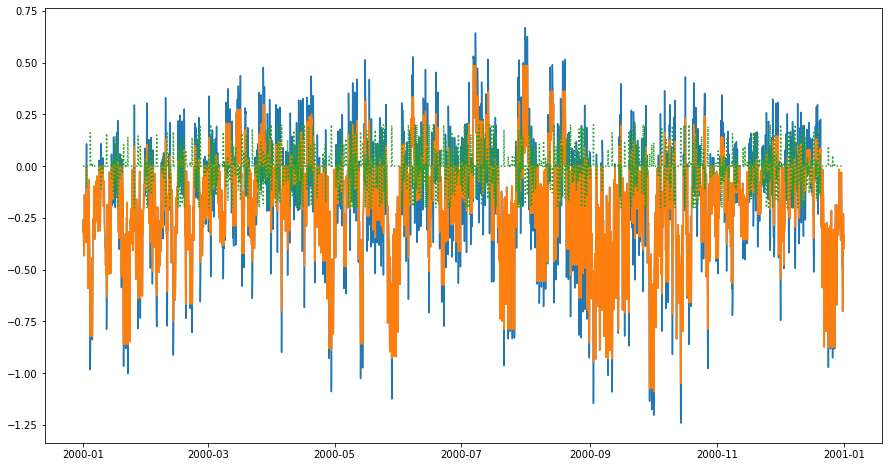

In [11]:
plt.figure(figsize=(15, 8))
plt.plot(df_residual.loc[df_residual.index.year==2000, 1])
plt.plot(df.loc[df.index.year==2000, 1])
plt.plot(df_charge.loc[df.index.year==2000, 1], linestyle=':')

plt.show()

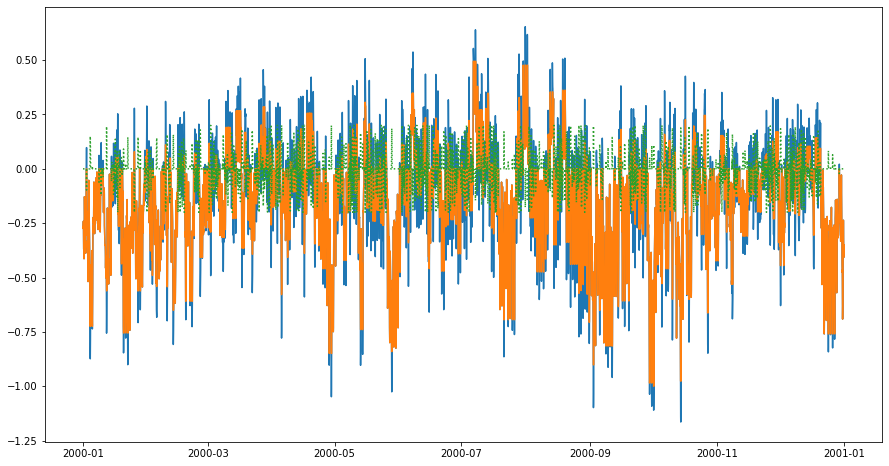

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(df_residual.loc[df_residual.index.year==2000, 2])
plt.plot(df.loc[df.index.year==2000, 2])
plt.plot(df_charge.loc[df.index.year==2000, 2], linestyle=':')

plt.show()

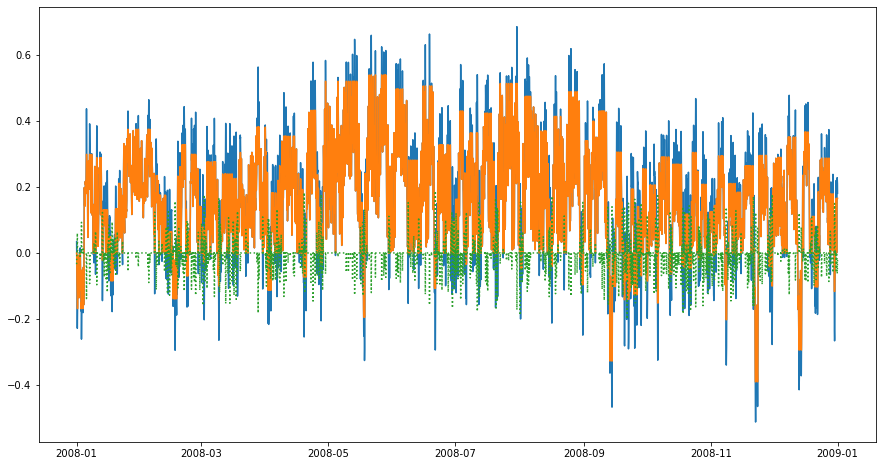

In [13]:
plt.figure(figsize=(15, 8))
plt.plot(df_residual.loc[df_residual.index.year==2008, 12])
plt.plot(df.loc[df.index.year==2008, 12])
plt.plot(df_charge.loc[df.index.year==2008, 12], linestyle=':')

plt.show()

In [14]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,8.767200e+04,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,8.767200e+04,8.767200e+04,87672.000000,8.767200e+04,8.767200e+04,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,8.767200e+04,8.767200e+04
mean,-1.549976e-01,-0.125494,-0.112244,-0.093790,-0.065322,-0.044067,-1.248119e-02,1.195065e-02,0.049571,7.900814e-02,1.039020e-01,0.144411,0.178421,0.208476,0.235926,0.287085,3.331179e-01,3.419569e-01
std,2.616426e-01,0.241398,0.234066,0.224548,0.211787,0.203362,1.918194e-01,1.837243e-01,0.172151,1.641653e-01,1.582584e-01,0.149576,0.143173,0.138114,0.133564,0.124455,1.169785e-01,1.168926e-01
min,-1.161405e+00,-1.077507,-1.044261,-1.000246,-0.933279,-0.881561,-8.037291e-01,-7.453520e-01,-0.651621,-5.789526e-01,-5.200718e-01,-0.429779,-0.354639,-0.283607,-0.203162,-0.061375,-3.827356e-10,-1.969652e-10
25%,-3.146072e-01,-0.272030,-0.254640,-0.230552,-0.192875,-0.165316,-1.224915e-01,-8.981095e-02,-0.039802,-2.949155e-07,-2.596904e-10,0.027884,0.073055,0.110409,0.144406,0.203994,2.558890e-01,2.651310e-01
50%,-1.122410e-01,-0.087850,-0.075053,-0.056371,-0.026550,-0.004083,-2.183698e-10,8.128374e-09,0.037212,7.070599e-02,9.822837e-02,0.141067,0.176878,0.207541,0.234718,0.284292,3.293002e-01,3.383123e-01
75%,7.098039e-08,0.015937,0.025112,0.038827,0.061659,0.080152,1.068788e-01,1.280917e-01,0.161291,1.879779e-01,2.097085e-01,0.246210,0.276315,0.301714,0.325300,0.369083,4.084254e-01,4.169823e-01
max,5.729000e-01,0.574026,0.575111,0.576996,0.581017,0.584769,5.909443e-01,5.962389e-01,0.604805,6.118076e-01,6.180006e-01,0.627506,0.654103,0.671207,0.677883,0.712763,7.690614e-01,7.736760e-01


In [15]:
df_residual.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000
mean,-0.154998,-0.125494,-0.112244,-0.093790,-0.065322,-0.044067,-0.012481,0.011951,0.049571,0.079008,0.103902,0.144411,0.178421,0.208476,0.235926,0.287085,0.333118,0.341957
std,0.286710,0.266544,0.259305,0.249913,0.237081,0.228495,0.216595,0.207935,0.195162,0.185694,0.178032,0.165851,0.155924,0.147426,0.139891,0.126701,0.117552,0.117397
min,-1.319523,-1.230976,-1.192645,-1.142132,-1.069263,-1.019387,-0.943282,-0.883987,-0.786934,-0.709335,-0.646949,-0.550874,-0.468917,-0.397260,-0.333250,-0.216820,-0.145527,-0.143439
25%,-0.327589,-0.287690,-0.271318,-0.248082,-0.212487,-0.186541,-0.148544,-0.119128,-0.074030,-0.039136,-0.010035,0.037830,0.077783,0.113055,0.145218,0.204086,0.255889,0.265131
50%,-0.130212,-0.106283,-0.094563,-0.077913,-0.051484,-0.031860,-0.002469,0.021107,0.056583,0.084683,0.108068,0.146941,0.179875,0.208747,0.235152,0.284320,0.329316,0.338326
75%,0.042744,0.057060,0.065190,0.076735,0.096232,0.111015,0.133891,0.151909,0.180431,0.203084,0.222216,0.254113,0.280955,0.304747,0.326920,0.369204,0.408478,0.416997
max,0.736450,0.732590,0.731550,0.730175,0.733121,0.737240,0.743646,0.746745,0.753157,0.758633,0.763028,0.770415,0.776969,0.782655,0.788364,0.798284,0.808225,0.814752


In [16]:
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
AEST,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,-0.315999,-0.273601,-0.258247,-0.234049,-0.195486,-0.170762,-1.333950e-01,-1.050722e-01,-6.560424e-02,-0.036653,-0.014922,8.050043e-11,1.522599e-08,0.084940,0.112313,0.166096,0.241798,0.252072
2000-01-01 01:00:00,-0.307122,-0.267180,-0.252944,-0.230370,-0.193428,-0.169689,-1.337058e-01,-1.065147e-01,-6.934721e-02,-0.042304,-0.021751,8.049221e-11,1.522412e-08,0.075715,0.102729,0.156107,0.232034,0.242798
2000-01-01 02:00:00,-0.308337,-0.272727,-0.260088,-0.239732,-0.205607,-0.183596,-1.501933e-01,-1.247661e-01,-9.004735e-02,-0.064790,-0.045381,-9.531671e-03,1.521134e-08,0.049138,0.075423,0.127133,0.200571,0.211641
2000-01-01 03:00:00,-0.291623,-0.263891,-0.253862,-0.236970,-0.207141,-0.187550,-1.575972e-01,-1.341688e-01,-1.016670e-01,-0.077778,-0.059047,-2.407677e-02,1.515875e-08,0.033766,0.059489,0.109548,0.178933,0.189809
2000-01-01 04:00:00,-0.278602,-0.259734,-0.252352,-0.238957,-0.213332,-0.195735,-1.685245e-01,-1.463747e-01,-1.148056e-01,-0.091168,-0.072051,-3.664279e-02,-5.539153e-03,0.022130,0.047993,0.097765,0.163315,0.173001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 19:00:00,-0.097862,-0.080270,-0.069448,-0.054036,-0.033265,-0.016849,1.023373e-09,3.881855e-10,3.115504e-10,0.005728,0.028611,7.032687e-02,1.080382e-01,0.217529,0.245972,0.294435,0.364269,0.371378
2009-12-31 20:00:00,-0.078661,-0.070389,-0.063227,-0.052777,-0.037931,-0.025427,-7.819307e-03,3.876679e-10,3.113774e-10,0.005728,0.028611,7.032687e-02,1.080382e-01,0.192693,0.221792,0.271087,0.336354,0.345669
2009-12-31 21:00:00,-0.085068,-0.077824,-0.071778,-0.063771,-0.051569,-0.041473,-2.687813e-02,-1.471146e-02,3.104954e-10,0.005728,0.028611,7.032686e-02,1.080382e-01,0.168183,0.200109,0.254646,0.320786,0.327570


In [17]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,8.767200e+04,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,8.767200e+04,8.767200e+04,87672.000000,8.767200e+04,8.767200e+04,87672.000000,87672.000000,87672.000000,87672.000000,87672.000000,8.767200e+04,8.767200e+04
mean,-1.549976e-01,-0.125494,-0.112244,-0.093790,-0.065322,-0.044067,-1.248119e-02,1.195065e-02,0.049571,7.900814e-02,1.039020e-01,0.144411,0.178421,0.208476,0.235926,0.287085,3.331179e-01,3.419569e-01
std,2.616426e-01,0.241398,0.234066,0.224548,0.211787,0.203362,1.918194e-01,1.837243e-01,0.172151,1.641653e-01,1.582584e-01,0.149576,0.143173,0.138114,0.133564,0.124455,1.169785e-01,1.168926e-01
min,-1.161405e+00,-1.077507,-1.044261,-1.000246,-0.933279,-0.881561,-8.037291e-01,-7.453520e-01,-0.651621,-5.789526e-01,-5.200718e-01,-0.429779,-0.354639,-0.283607,-0.203162,-0.061375,-3.827356e-10,-1.969652e-10
25%,-3.146072e-01,-0.272030,-0.254640,-0.230552,-0.192875,-0.165316,-1.224915e-01,-8.981095e-02,-0.039802,-2.949155e-07,-2.596904e-10,0.027884,0.073055,0.110409,0.144406,0.203994,2.558890e-01,2.651310e-01
50%,-1.122410e-01,-0.087850,-0.075053,-0.056371,-0.026550,-0.004083,-2.183698e-10,8.128374e-09,0.037212,7.070599e-02,9.822837e-02,0.141067,0.176878,0.207541,0.234718,0.284292,3.293002e-01,3.383123e-01
75%,7.098039e-08,0.015937,0.025112,0.038827,0.061659,0.080152,1.068788e-01,1.280917e-01,0.161291,1.879779e-01,2.097085e-01,0.246210,0.276315,0.301714,0.325300,0.369083,4.084254e-01,4.169823e-01
max,5.729000e-01,0.574026,0.575111,0.576996,0.581017,0.584769,5.909443e-01,5.962389e-01,0.604805,6.118076e-01,6.180006e-01,0.627506,0.654103,0.671207,0.677883,0.712763,7.690614e-01,7.736760e-01


In [19]:
df-df_residual

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
AEST,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,9.742173e-10,1.262409e-09,1.994590e-09,9.416449e-10,1.133673e-09,2.139091e-09,9.501291e-10,3.004467e-09,1.224536e-10,1.434808e-09,8.240408e-10,-2.327176e-02,-5.566976e-02,-4.919800e-09,-2.720450e-11,-2.054323e-11,-1.668454e-11,-3.156586e-11
2000-01-01 01:00:00,9.574800e-10,1.244715e-09,1.969992e-09,9.329660e-10,1.127202e-09,2.132175e-09,9.511568e-10,3.021515e-09,1.252476e-10,1.494580e-09,8.733068e-10,-1.540291e-02,-4.713509e-02,-2.877379e-09,-2.571281e-11,-2.002290e-11,-1.625564e-11,-3.113146e-11
2000-01-01 02:00:00,9.597370e-10,1.259969e-09,2.003275e-09,9.553684e-10,1.166619e-09,2.225462e-09,1.009051e-09,3.255232e-09,1.433308e-10,1.791513e-09,1.099049e-09,9.286226e-11,-2.139923e-02,-1.310169e-09,-2.223875e-11,-1.865227e-11,-1.510286e-11,-2.949654e-11
2000-01-01 03:00:00,9.295954e-10,1.235842e-09,1.974204e-09,9.486498e-10,1.171783e-09,2.253496e-09,1.037405e-09,3.390331e-09,1.559710e-10,2.023703e-09,1.291779e-09,1.214145e-10,-6.488675e-03,-9.962711e-10,-2.061335e-11,-1.790744e-11,-1.442951e-11,-2.854020e-11
2000-01-01 04:00:00,9.073944e-10,1.224806e-09,1.967285e-09,9.534733e-10,1.193085e-09,2.313824e-09,1.082289e-09,3.583382e-09,1.732465e-10,2.335803e-09,1.550441e-09,1.652645e-10,3.116389e-08,-8.433247e-10,-1.958064e-11,-1.744070e-11,-1.399794e-11,-2.807002e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 19:00:00,1.108774e-10,1.577194e-09,4.238593e-11,1.893990e-09,5.934446e-10,5.335018e-11,-5.659957e-03,-2.430649e-02,-5.937420e-02,-8.238240e-02,-8.319933e-02,-8.158462e-02,-7.811455e-02,-2.057209e-10,-3.704198e-11,-1.519347e-10,-4.009071e-12,-5.819456e-12
2009-12-31 20:00:00,1.070288e-10,1.547449e-09,4.186120e-11,1.888944e-09,5.998596e-10,5.459837e-11,1.045453e-09,-7.497713e-03,-3.843553e-02,-5.871627e-02,-5.759911e-02,-5.512567e-02,-5.280009e-02,-1.430623e-10,-3.365230e-11,-1.387498e-10,-3.571088e-12,-5.192180e-12
2009-12-31 21:00:00,1.082305e-10,1.569726e-09,4.258599e-11,1.933754e-09,6.194235e-10,5.692036e-11,1.102936e-09,4.058827e-10,-1.218319e-02,-2.941998e-02,-2.601877e-02,-2.467583e-02,-2.602065e-02,-1.100053e-10,-3.110021e-11,-1.307610e-10,-3.366474e-12,-4.826084e-12


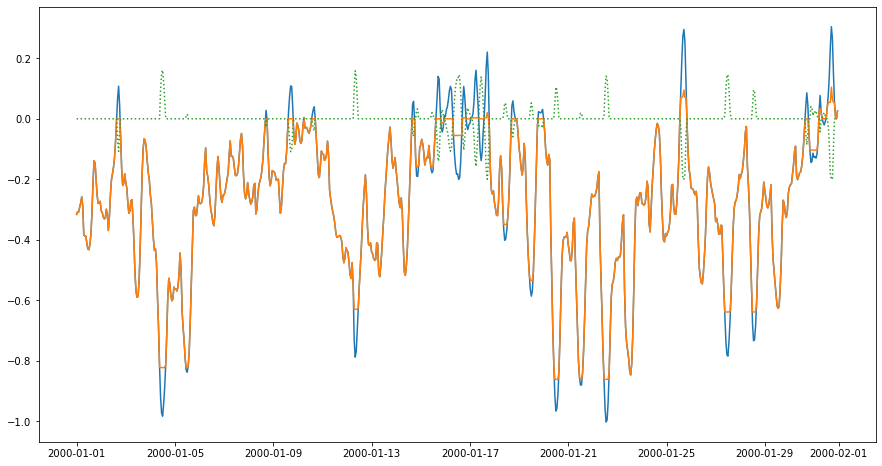

In [20]:
plt.figure(figsize=(15, 8))
plt.plot(df_residual.loc[(df_residual.index.year==2000) & (df_residual.index.month==1), 1])
plt.plot(df.loc[(df.index.year==2000) & (df.index.month==1), 1])
plt.plot(df_charge.loc[(df_charge.index.year==2000) & (df_charge.index.month==1), 1], linestyle=':')

plt.show()

In [22]:
df_residual.loc[(df_residual.index>=pd.to_datetime('2000-01-04 00:00:00')) & 
                (df_residual.index<=pd.to_datetime('2000-01-04 23:00:00')), 1]

AEST
2000-01-04 00:00:00   -0.250338
2000-01-04 01:00:00   -0.281614
2000-01-04 02:00:00   -0.337741
2000-01-04 03:00:00   -0.398307
2000-01-04 04:00:00   -0.435355
2000-01-04 05:00:00   -0.429167
2000-01-04 06:00:00   -0.477735
2000-01-04 07:00:00   -0.592125
2000-01-04 08:00:00   -0.692036
2000-01-04 09:00:00   -0.821039
2000-01-04 10:00:00   -0.921759
2000-01-04 11:00:00   -0.973844
2000-01-04 12:00:00   -0.983332
2000-01-04 13:00:00   -0.941341
2000-01-04 14:00:00   -0.887342
2000-01-04 15:00:00   -0.812740
2000-01-04 16:00:00   -0.714885
2000-01-04 17:00:00   -0.591879
2000-01-04 18:00:00   -0.527414
2000-01-04 19:00:00   -0.545372
2000-01-04 20:00:00   -0.584030
2000-01-04 21:00:00   -0.601702
2000-01-04 22:00:00   -0.595637
2000-01-04 23:00:00   -0.556195
Name: 1, dtype: float64